In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.isomorphism import GraphMatcher
from networkx.algorithms import isomorphism
import itertools
import networkx as nx

# Complete

## Parse Input Files, Get Atom Types

In [ ]:
def parse_itp_file(file_path):
    data = {}
    current_section = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(';') or not line:
                continue
            elif line.startswith('[') and line.endswith(']'):
                current_section = line[1:-1].strip()
                data[current_section] = []
                if current_section in ['angles', 'moleculetype', 'atoms']:
                    next(file)  # Skip one line for certain sections
            else:
                line_data = line.split(';')[0].strip()
                if line_data:
                    if current_section == 'dihedrals':
                        if 'IMPROPER DIHEDRAL' in line_data:
                            next(file)  # Skip the next line for improper dihedrals
                            continue
                        elif 'PROPER DIHEDRAL' in line_data:
                            next(file)  # Skip the next line for proper dihedrals
                            continue
                    data[current_section].append(line_data.split())

    return data

def process_dihedrals_sections(file_path):
    improper_data = []
    proper_data = []
    with open(file_path, 'r') as file:
        section_flag = None  # Tracks the current section
        dihedrals_flag = False  # Flag to indicate dihedrals section
        section_type = None  # Tracks the type of dihedrals section
        for line in file:
            line = line.strip()
            if line.startswith('[ dihedrals ]'):
                dihedrals_flag = True
            elif dihedrals_flag and line.startswith('; IMPROPER DIHEDRAL ANGLES'):
                section_flag = 'improper'
                section_type = 'Improper Dihedrals'
            elif dihedrals_flag and line.startswith('; PROPER DIHEDRAL ANGLES'):
                section_flag = 'proper'
                section_type = 'Proper Dihedrals'
            elif '[ pairs ]' in line:
                break  # Stop collecting data after encountering [ pairs ]
            elif section_flag == 'improper' and line.strip() and not line.startswith(';'):
                improper_data.append(line.split())
            elif section_flag == 'proper' and line.strip() and not line.startswith(';'):
                proper_data.append(line.split())

    # Convert data to dataframes
    df_improper = pd.DataFrame(improper_data, columns=['ai', 'aj', 'ak', 'al', 'funct', 'c0', 'c1', 'c2'])
    df_proper = pd.DataFrame(proper_data, columns=['ai', 'aj', 'ak', 'al', 'funct', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5'])

    return df_improper, df_proper

def parse_to_dataframes(file_path):
    data = parse_itp_file(file_path)
    df_improper, df_proper = process_dihedrals_sections(file_path)

    # Convert other sections to dataframes
    df_atomtypes = pd.DataFrame(data['atomtypes'], columns=['name', 'bond_type', 'mass', 'charge', 'ptype', 'sigma', 'epsilon'])
    df_atoms = pd.DataFrame(data['atoms'], columns=['nr', 'type', 'resnr', 'residue', 'atom', 'cgnr', 'charge', 'mass'])
    df_bonds = pd.DataFrame(data['bonds'], columns=['ai', 'aj', 'funct', 'b0', 'kb'])
    df_angles = pd.DataFrame(data['angles'], columns=['ai', 'aj', 'ak', 'funct', 'theta0', 'cth'])

    return df_atomtypes, df_atoms, df_bonds, df_angles, df_proper, df_improper

# Parse the test_1mer.itp and test_3mer.itp files
df1_atomtypes, df1_atoms, df1_bonds, df1_angles, df1_proper, df1_improper = parse_to_dataframes('test_1mer.itp')
df3_atomtypes, df3_atoms, df3_bonds, df3_angles, df3_proper, df3_improper = parse_to_dataframes('test_3mer.itp')


print(df1_atomtypes)
print(df1_atoms)
print(df1_bonds)
print(df1_angles)
print(df1_proper)
print(df1_improper)

print(df3_atomtypes)
print(df3_atoms)
print(df3_bonds)
print(df3_angles)
print(df3_proper)
print(df3_improper)

          name bond_type     mass charge ptype        sigma      epsilon
0    opls_9507      H507   1.0080  0.000     A  2.50000E-01  1.25520E-01
1     opls_888      C888  12.0110  0.000     A  3.50000E-01  2.76144E-01
2     opls_842      C842  12.0110  0.000     A  3.50000E-01  2.76144E-01
3     opls_828      H828   1.0080  0.000     A  2.50000E-01  1.25520E-01
4     opls_875      H875   1.0080  0.000     A  2.50000E-01  1.25520E-01
..         ...       ...      ...    ...   ...          ...          ...
105   opls_803      C803  12.0110  0.000     A  3.55000E-01  2.92880E-01
106   opls_853      H853   1.0080  0.000     A  2.50000E-01  1.25520E-01
107   opls_882      C882  12.0110  0.000     A  3.50000E-01  2.76144E-01
108  opls_9509      H509   1.0080  0.000     A  2.50000E-01  1.25520E-01
109   opls_859      H859   1.0080  0.000     A  2.50000E-01  1.25520E-01

[110 rows x 7 columns]
      nr       type resnr residue atom cgnr   charge     mass
0      1   opls_800     1     UNK  C00

In [ ]:
# List of atomic symbols from the periodic table
atomic_symbols = [
    "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
    "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr",
    "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn",
    "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd",
    "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
    "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg",
    "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th",
    "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm",
    "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds",
    "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
]

def split_atom_name(df):
    atom_name_col = []
    atom_namnum_col = []

    for atom in df['atom']:
        atom_name = None
        atom_namnum = None

        # Check if the atom name starts with an atomic symbol
        for symbol in atomic_symbols:
            if atom.startswith(symbol):
                # Check if there are additional characters after the atomic symbol
                if len(atom) > len(symbol):
                    next_char = atom[len(symbol)]
                    if next_char.isdigit() or (next_char.isalpha() and next_char.isupper()):
                        atom_name = symbol
                        atom_namnum = atom[len(symbol):]
                        break
                    elif next_char.isalpha() and next_char.islower():
                        # Check if the full atom name matches any atomic symbol
                        if atom in atomic_symbols:
                            atom_name = atom
                            break

        if atom_name is None:
            raise ValueError(f"Atomic symbol not found in atom: {atom}")

        atom_name_col.append(atom_name)
        atom_namnum_col.append(atom_namnum)

    df['atom_name'] = atom_name_col
    df['atom_namnum'] = atom_namnum_col
    df.drop(columns=['atom'], inplace=True)

    return df

df = split_atom_name(df1_atoms)
print(df1_atoms)

df = split_atom_name(df3_atoms)
print(df3_atoms)

      nr       type resnr residue cgnr   charge     mass atom_name atom_namnum
0      1   opls_800     1     UNK    1  -0.2431  12.0110         C          00
1      2   opls_801     1     UNK    1  -0.1455  12.0110         C          01
2      3   opls_802     1     UNK    1  -0.0859  12.0110         C          02
3      4   opls_803     1     UNK    1  -0.0805  12.0110         C          03
4      5   opls_804     1     UNK    1   0.0763  32.0600         S          04
..   ...        ...   ...     ...  ...      ...      ...       ...         ...
105  106  opls_9505     1     UNK    4   0.0898   1.0080         H          30
106  107  opls_9506     1     UNK    4  -0.2371  12.0110         C          31
107  108  opls_9507     1     UNK    4   0.0814   1.0080         H          32
108  109  opls_9508     1     UNK    4   0.0814   1.0080         H          33
109  110  opls_9509     1     UNK    4   0.0814   1.0080         H          34

[110 rows x 9 columns]
    nr      type resnr resid

In [ ]:
def lookup_atom(row, column_name):
    try:
        atom_number = str(row[column_name])  # Convert atom number to integer explicitly
    except ValueError:
        return 'Unknown'

    matched_atoms = df1_atoms.loc[df1_atoms['nr'] == atom_number, 'atom_name'].values

    if len(matched_atoms) > 0:
        return matched_atoms[0]
    else:
        return 'Unknown'

# List of df1_ dataframes to apply the lookup function to
df1_dataframes = [df1_bonds, df1_angles, df1_proper, df1_improper]

# Loop through each dataframe and apply the lookup function to ai, aj, ak, al columns
for df in df1_dataframes:
    if 'ai' in df.columns:
        df['ai_atom'] = df.apply(lambda row: lookup_atom(row, 'ai'), axis=1)
    if 'aj' in df.columns:
        df['aj_atom'] = df.apply(lambda row: lookup_atom(row, 'aj'), axis=1)
    if 'ak' in df.columns:
        df['ak_atom'] = df.apply(lambda row: lookup_atom(row, 'ak'), axis=1)
    if 'al' in df.columns:
        df['al_atom'] = df.apply(lambda row: lookup_atom(row, 'al'), axis=1)

# Print the updated dataframes
print("Updated df1_bonds:")
print(df1_bonds)
print("\nUpdated df1_angles:")
print(df1_angles)
print("\nUpdated df1_proper:")
print(df1_proper)
print("\nUpdated df1_improper:")
print(df1_improper)

Updated df1_bonds:
      ai   aj funct      b0          kb ai_atom aj_atom
0      2    1     1  0.1367  456892.800       C       C
1      3    2     1  0.1424  392459.200       C       C
2      4    3     1  0.1424  392459.200       C       C
3      5    1     1  0.1740  209200.000       S       C
4      6    1     1  0.1080  307105.600       H       C
..   ...  ...   ...     ...         ...     ...     ...
108  110  107     1  0.1090  284512.000       H       C
109    5    4     1  0.1760  209200.000       S       C
110   13   11     1  0.1424  392459.200       C       C
111   17   16     1  0.1760  209200.000       S       C
112   22   21     1  0.1367  456892.800       C       C

[113 rows x 7 columns]

Updated df1_angles:
      ai   aj   ak funct   theta0      cth ai_atom aj_atom ak_atom
0      1    2    3     1  107.300  585.760       C       C       C
1      2    3    4     1  120.000  527.184       C       C       C
2      2    1    5     1  111.170  585.760       C       C     

In [ ]:
def lookup_atom(row, column_name):
    try:
        atom_number = str(row[column_name])  # Convert atom number to integer explicitly
    except ValueError:
        return 'Unknown'

    matched_atoms = df3_atoms.loc[df3_atoms['nr'] == atom_number, 'atom_name'].values

    if len(matched_atoms) > 0:
        return matched_atoms[0]
    else:
        return 'Unknown'

# List of df3_ dataframes to apply the lookup function to
df3_dataframes = [df3_bonds, df3_angles, df3_proper, df3_improper]

# Loop through each dataframe and apply the lookup function to ai, aj, ak, al columns
for df in df3_dataframes:
    if 'ai' in df.columns:
        df['ai_atom'] = df.apply(lambda row: lookup_atom(row, 'ai'), axis=1)
    if 'aj' in df.columns:
        df['aj_atom'] = df.apply(lambda row: lookup_atom(row, 'aj'), axis=1)
    if 'ak' in df.columns:
        df['ak_atom'] = df.apply(lambda row: lookup_atom(row, 'ak'), axis=1)
    if 'al' in df.columns:
        df['al_atom'] = df.apply(lambda row: lookup_atom(row, 'al'), axis=1)

# Print the updated dataframes
print("Updated df3_bonds:")
print(df3_bonds)
print("\nUpdated df3_angles:")
print(df3_angles)
print("\nUpdated df3_proper:")
print(df3_proper)
print("\nUpdated df3_improper:")
print(df3_improper)

Updated df3_bonds:
     ai  aj funct      b0          kb ai_atom aj_atom
0     2   1     1  0.1424  392459.200       C       C
1     3   2     1  0.1424  392459.200       C       C
2     4   3     1  0.1424  392459.200       C       C
3     5   1     1  0.1760  209200.000       S       C
4     6   2     1  0.1080  307105.600       H       C
..   ..  ..   ...     ...         ...     ...     ...
98   57  55     1  0.1424  392459.200       C       C
99   67  65     1  0.1424  392459.200       C       C
100  77  75     1  0.1424  392459.200       C       C
101  80  79     1  0.1424  392459.200       C       C
102  87  85     1  0.1367  456892.800       C       C

[103 rows x 7 columns]

Updated df3_angles:
     ai  aj  ak funct   theta0      cth ai_atom aj_atom ak_atom
0     1   2   3     1  120.000  527.184       C       C       C
1     2   3   4     1  120.000  527.184       C       C       C
2     2   1   5     1  119.400  711.280       C       C       S
3     1   2   6     1  127.500  

## Graph setup to find sidechain vs backbone vertices

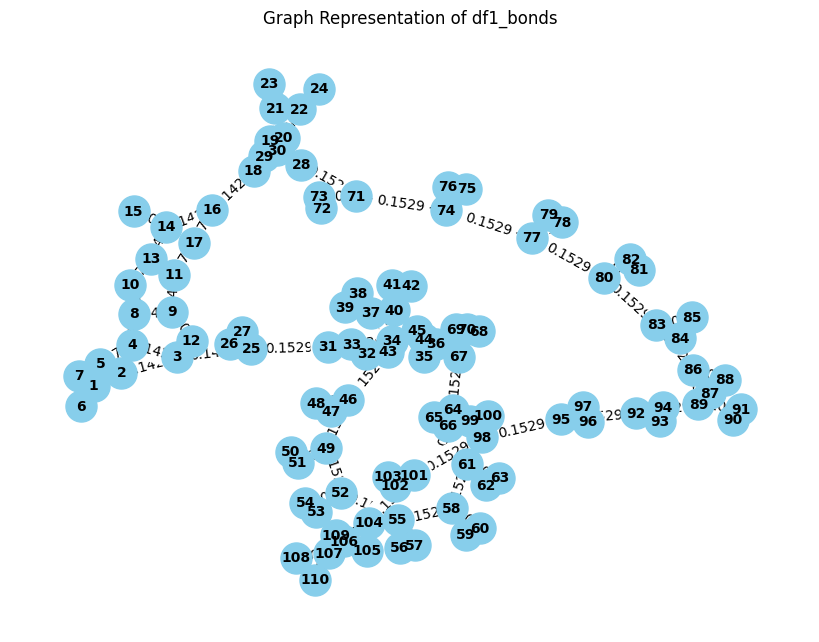

Backbone Nodes: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110}
Sidechain Nodes: {'sidechain_1': {31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70}}
sidechain_1 Matches:
    nr      type resnr residue cgnr   charge     mass atom_name atom_namnum
30  31  opls_830     1     UNK    1  -0.1889  12.0110         C          0V
31  32  opls_831     1     UNK    1   0.1067   1.0080         H          0W
32  33  opls_832     1     UNK    2   0.1067   1.0080         H          0X
33  34  opls_833     1     UNK    2  -0.1935  12.0110         C          0Y
34  35  opls_834     1     UNK    2   0.1093   1.0080         H          0Z
35  36  opls_835     1     UN

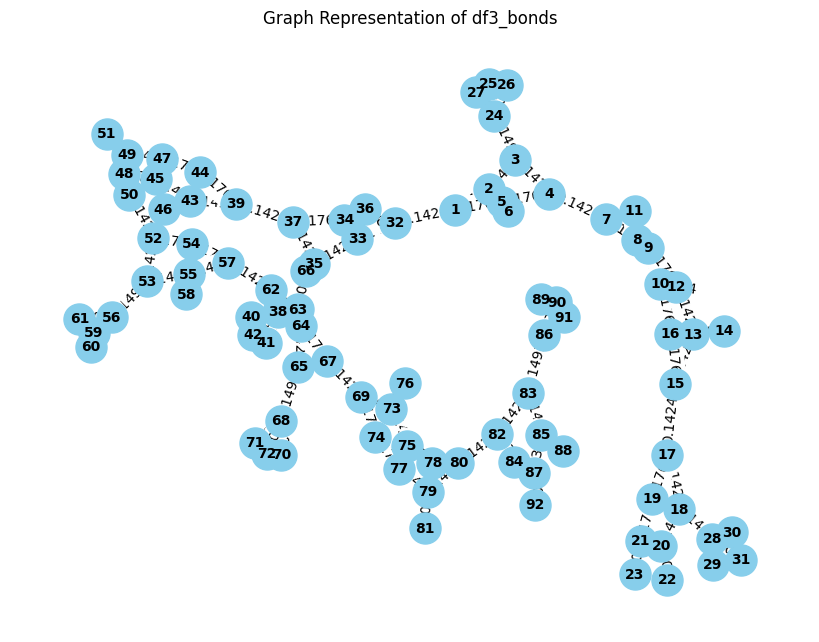

Backbone Nodes: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92}
Sidechain Nodes: {'sidechain_1': {29}, 'sidechain_2': {25}, 'sidechain_3': {42}, 'sidechain_4': {60}, 'sidechain_5': {72}, 'sidechain_6': {91}}
sidechain_1 Matches:
    nr      type resnr residue cgnr  charge    mass atom_name atom_namnum
28  29  opls_828     1     UNK    1  0.0997  1.0080         H          0T

sidechain_2 Matches:
    nr      type resnr residue cgnr  charge    mass atom_name atom_namnum
24  25  opls_824     1     UNK    1  0.1008  1.0080         H          0P

sidechain_3 Matches:
    nr      type resnr residue cgnr  charge    mass atom_name atom_namnum
41  42  opls_841     1     UNK    2  0.1010  1.0080         H        

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Function to create a graph from the DataFrame
def bonds_to_graph(df_bonds):
    G = nx.Graph()
    for _, row in df_bonds.iterrows():
        G.add_edge(int(row['ai']), int(row['aj']), funct=row['funct'], b0=row['b0'], kb=row['kb'])
    return G

# Function to draw the graph
def draw_graph(G, title="Graph Representation"):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'b0')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Function to identify backbone and separate sidechains with proper integer handling
def identify_sidechains(G, sidechain_bonds):
    backbone_nodes = set(G.nodes())
    sidechains = {}

    for i, (backbone_node, sidechain_node) in enumerate(sidechain_bonds, start=1):
        backbone_node, sidechain_node = int(backbone_node), int(sidechain_node)

        if G.has_edge(backbone_node, sidechain_node):
            G.remove_edge(backbone_node, sidechain_node)

        current_backbone_nodes = set(nx.node_connected_component(G, backbone_node))
        backbone_nodes &= current_backbone_nodes

        current_sidechain_nodes = set(G.nodes()) - current_backbone_nodes
        sidechains[f'sidechain_{i}'] = current_sidechain_nodes

        G.add_edge(backbone_node, sidechain_node)

    return backbone_nodes, sidechains

# Function to search df_atoms for each sidechain's nr values
def search_sidechains_in_df(df_atoms, sidechains):
    df_atoms['nr'] = df_atoms['nr'].astype(int)
    sidechain_data = {}
    for sidechain, nodes in sidechains.items():
        nodes = set(map(int, nodes))
        matching_rows = df_atoms[df_atoms['nr'].isin(nodes)]
        sidechain_data[sidechain] = matching_rows

    return sidechain_data

# Process df1_bonds
G1 = bonds_to_graph(df1_bonds)
draw_graph(G1, title="Graph Representation of df1_bonds")
sidechain_bond1 = [(25,31)]
backbone_nodes, sidechain_nodes = identify_sidechains(G1, sidechain_bond1)
print("Backbone Nodes:", backbone_nodes)
print("Sidechain Nodes:", sidechain_nodes)
m1_sc_matches = search_sidechains_in_df(df1_atoms, sidechain_nodes)
for sidechain, matching_rows in m1_sc_matches.items():
    print(f"{sidechain} Matches:")
    print(matching_rows)
    print()

# Process df3_bonds
G3 = bonds_to_graph(df3_bonds)
draw_graph(G3, title="Graph Representation of df3_bonds")
sidechain_bonds3 = [(28,29), (24,25), (38,42), (56,60), (68,72), (86,91)]
backbone_nodes, all_sidechain_nodes = identify_sidechains(G3, sidechain_bonds3)
print("Backbone Nodes:", backbone_nodes)
print("Sidechain Nodes:", all_sidechain_nodes)
m3_sc_matches = search_sidechains_in_df(df3_atoms, all_sidechain_nodes)
for sidechain, matching_rows in m3_sc_matches.items():
    print(f"{sidechain} Matches:")
    print(matching_rows)
    print()

In [ ]:
# Create the sc_atoms DataFrame using the output from m1_sc_matches
df_sc_atoms = m1_sc_matches['sidechain_1'].copy()

# Display the df_sc_atoms DataFrame
print("df_sc_atoms DataFrame:")
print(df_sc_atoms)

df_sc_atoms DataFrame:
    nr      type resnr residue cgnr   charge     mass atom_name atom_namnum
30  31  opls_830     1     UNK    1  -0.1889  12.0110         C          0V
31  32  opls_831     1     UNK    1   0.1067   1.0080         H          0W
32  33  opls_832     1     UNK    2   0.1067   1.0080         H          0X
33  34  opls_833     1     UNK    2  -0.1935  12.0110         C          0Y
34  35  opls_834     1     UNK    2   0.1093   1.0080         H          0Z
35  36  opls_835     1     UNK    2   0.1093   1.0080         H          10
36  37  opls_836     1     UNK    2  -0.1752  12.0110         C          11
37  38  opls_837     1     UNK    2   0.0936   1.0080         H          12
38  39  opls_838     1     UNK    2   0.0936   1.0080         H          13
39  40  opls_839     1     UNK    2  -0.1851  12.0110         C          14
40  41  opls_840     1     UNK    2   0.0920   1.0080         H          15
41  42  opls_841     1     UNK    2   0.0920   1.0080         H  

In [ ]:
# Initialize an empty DataFrame for m3sc_atoms
m3sc_atoms = pd.DataFrame()

# Iterate through m3_sc_matches to construct the DataFrame
for sc_num, (sidechain, matching_rows) in enumerate(m3_sc_matches.items(), start=1):
    matching_rows = matching_rows.copy()  # Copy the DataFrame to avoid modifying the original
    matching_rows['sc_num'] = sc_num  # Add the sc_num column
    m3sc_atoms = pd.concat([m3sc_atoms, matching_rows], ignore_index=True)

# Display the m3sc_atoms DataFrame
print("\nm3sc_atoms DataFrame:")
print(m3sc_atoms)


m3sc_atoms DataFrame:
   nr      type resnr residue cgnr  charge    mass atom_name atom_namnum  \
0  29  opls_828     1     UNK    1  0.0997  1.0080         H          0T   
1  25  opls_824     1     UNK    1  0.1008  1.0080         H          0P   
2  42  opls_841     1     UNK    2  0.1010  1.0080         H          16   
3  60  opls_859     1     UNK    2  0.1012  1.0080         H          1P   
4  72  opls_871     1     UNK    3  0.1009  1.0080         H          21   
5  91  opls_890     1     UNK    3  0.0997  1.0080         H          2K   

   sc_num  
0       1  
1       2  
2       3  
3       4  
4       5  
5       6  


## fix charges

In [ ]:
# Ensure the charge columns are converted to float
df_sc_atoms['charge'] = df_sc_atoms['charge'].astype(float)
m3sc_atoms['charge'] = m3sc_atoms['charge'].astype(float)

# Perform your calculations
sc_charge = df_sc_atoms['charge'].sum()
replace_charge = m3sc_atoms[m3sc_atoms['sc_num'] == 1]['charge'].sum()
adjustment_value = sc_charge - replace_charge

df_sc_atoms['abs'] = df_sc_atoms['charge'].abs()
df_sc_atoms['chg'] = df_sc_atoms['abs'] / df_sc_atoms['charge']
abs_charge = df_sc_atoms['abs'].sum()
df_sc_atoms['prcnt'] = df_sc_atoms['abs'] / abs_charge
df_sc_atoms['adj'] = df_sc_atoms['prcnt'] * adjustment_value
df_sc_atoms['adj1'] = df_sc_atoms['adj'] * df_sc_atoms['chg'] * -1
df_sc_atoms['adj2'] = df_sc_atoms['adj1'] + df_sc_atoms['abs']
df_sc_atoms['new_charge'] = df_sc_atoms['chg'] * df_sc_atoms['adj2']

df_sc_atoms['charge'] = df_sc_atoms['new_charge']

# Drop unnecesary columns
df_sc_atoms = df_sc_atoms.drop(columns=['abs', 'chg', 'prcnt', 'adj', 'adj1', 'adj2', 'new_charge'])

# Display the updated sc_atoms DataFrame
print(df_sc_atoms)

NameError: name 'df_sc_atoms' is not defined

## Build Sidechain itp

In [ ]:
# Ensure the 'type' column in df_sc_atoms and 'name' column in df1_atomtypes are of string type
df_sc_atoms['type'] = df_sc_atoms['type'].astype(str)
df1_atomtypes['name'] = df1_atomtypes['name'].astype(str)

# Initialize an empty dataframe to store the results
df_sc_atomtypes = pd.DataFrame()

# Loop through each row in df_sc_atoms
for index, row in df_sc_atoms.iterrows():
    # Get the 'type' value and search df1_atomtypes for the matching row
    type_value = row['type']
    matching_row = df1_atomtypes[df1_atomtypes['name'] == type_value]

    # Concatenate the matching row to df_sc_atomtypes
    df_sc_atomtypes = pd.concat([df_sc_atomtypes, matching_row], ignore_index=True)

# Display the resulting dataframe
print("df_sc_atomtypes:")
print(df_sc_atomtypes)

# Ensure the 'nr' column in df_sc_atoms and 'ai', 'aj' columns in df1_bonds are of string type
df_sc_atoms['nr'] = df_sc_atoms['nr'].astype(str)
df1_bonds['ai'] = df1_bonds['ai'].astype(str)
df1_bonds['aj'] = df1_bonds['aj'].astype(str)

# Initialize an empty dataframe to store the results
df_sc_bonds = pd.DataFrame()

# Loop through each row in df_sc_atoms
for index, row in df_sc_atoms.iterrows():
    # Get the 'nr' value and search df1_bonds for matching rows
    nr_value = row['nr']

    matching_rows_ai = df1_bonds[df1_bonds['ai'] == nr_value]
    matching_rows_aj = df1_bonds[df1_bonds['aj'] == nr_value]

    # Concatenate the matching rows to df_sc_bonds
    df_sc_bonds = pd.concat([df_sc_bonds, matching_rows_ai, matching_rows_aj], ignore_index=True)

# Display the resulting dataframe
print("df_sc_bonds:")
print(df_sc_bonds)

# Ensure the 'nr' column in df_sc_atoms and 'ai', 'aj', 'ak' columns in df1_angles are of string type
df1_angles['ai'] = df1_angles['ai'].astype(str)
df1_angles['aj'] = df1_angles['aj'].astype(str)
df1_angles['ak'] = df1_angles['ak'].astype(str)

# Initialize an empty dataframe to store the results
df_sc_angles = pd.DataFrame()

# Loop through each row in df_sc_atoms
for index, row in df_sc_atoms.iterrows():
    # Get the 'nr' value and search df1_angles for matching rows
    nr_value = row['nr']

    matching_rows_ai = df1_angles[df1_angles['ai'] == nr_value]
    matching_rows_aj = df1_angles[df1_angles['aj'] == nr_value]
    matching_rows_ak = df1_angles[df1_angles['ak'] == nr_value]

    # Concatenate the matching rows to df_sc_angles
    df_sc_angles = pd.concat([df_sc_angles, matching_rows_ai, matching_rows_aj, matching_rows_ak], ignore_index=True)

# Remove duplicates if the same row matches multiple columns
df_sc_angles = df_sc_angles.drop_duplicates()

# Display the resulting dataframe
print("df_sc_angles:")
print(df_sc_angles)

# Ensure the 'nr' column in df_sc_atoms and 'ai', 'aj', 'ak', 'al' columns in df1_proper are of string type
df1_proper['ai'] = df1_proper['ai'].astype(str)
df1_proper['aj'] = df1_proper['aj'].astype(str)
df1_proper['ak'] = df1_proper['ak'].astype(str)
df1_proper['al'] = df1_proper['al'].astype(str)

# Initialize an empty dataframe to store the results
df_sc_proper = pd.DataFrame()

# Loop through each row in df_sc_atoms
for index, row in df_sc_atoms.iterrows():
    # Get the 'nr' value and search df1_proper for matching rows
    nr_value = row['nr']

    matching_rows_ai = df1_proper[df1_proper['ai'] == nr_value]
    matching_rows_aj = df1_proper[df1_proper['aj'] == nr_value]
    matching_rows_ak = df1_proper[df1_proper['ak'] == nr_value]
    matching_rows_al = df1_proper[df1_proper['al'] == nr_value]

    # Concatenate the matching rows to df_sc_proper
    df_sc_proper = pd.concat([df_sc_proper, matching_rows_ai, matching_rows_aj, matching_rows_ak, matching_rows_al], ignore_index=True)

# Remove duplicates if the same row matches multiple columns
df_sc_proper = df_sc_proper.drop_duplicates()

# Display the resulting dataframe
print("df_sc_proper:")
print(df_sc_proper)

# Ensure the 'nr' column in df_sc_atoms and 'ai', 'aj', 'ak', 'al' columns in df1_improper are of string type
df1_improper['ai'] = df1_improper['ai'].astype(str)
df1_improper['aj'] = df1_improper['aj'].astype(str)
df1_improper['ak'] = df1_improper['ak'].astype(str)
df1_improper['al'] = df1_improper['al'].astype(str)

# Initialize an empty dataframe to store the results
df_sc_improper = pd.DataFrame()

# Loop through each row in df_sc_atoms
for index, row in df_sc_atoms.iterrows():
    # Get the 'nr' value and search df1_improper for matching rows
    nr_value = row['nr']

    matching_rows_ai = df1_improper[df1_improper['ai'] == nr_value]
    matching_rows_aj = df1_improper[df1_improper['aj'] == nr_value]
    matching_rows_ak = df1_improper[df1_improper['ak'] == nr_value]
    matching_rows_al = df1_improper[df1_improper['al'] == nr_value]

    # Concatenate the matching rows to df_sc_improper
    df_sc_improper = pd.concat([df_sc_improper, matching_rows_ai, matching_rows_aj, matching_rows_ak, matching_rows_al], ignore_index=True)

# Remove duplicates if the same row matches multiple columns
df_sc_improper = df_sc_improper.drop_duplicates()

# Display the resulting dataframe
print("df_sc_improper:")
print(df_sc_improper)


df_sc_atomtypes:
        name bond_type     mass charge ptype        sigma      epsilon
0   opls_830      C830  12.0110  0.000     A  3.50000E-01  2.76144E-01
1   opls_831      H831   1.0080  0.000     A  2.50000E-01  1.25520E-01
2   opls_832      H832   1.0080  0.000     A  2.50000E-01  1.25520E-01
3   opls_833      C833  12.0110  0.000     A  3.50000E-01  2.76144E-01
4   opls_834      H834   1.0080  0.000     A  2.50000E-01  1.25520E-01
5   opls_835      H835   1.0080  0.000     A  2.50000E-01  1.25520E-01
6   opls_836      C836  12.0110  0.000     A  3.50000E-01  2.76144E-01
7   opls_837      H837   1.0080  0.000     A  2.50000E-01  1.25520E-01
8   opls_838      H838   1.0080  0.000     A  2.50000E-01  1.25520E-01
9   opls_839      C839  12.0110  0.000     A  3.50000E-01  2.76144E-01
10  opls_840      H840   1.0080  0.000     A  2.50000E-01  1.25520E-01
11  opls_841      H841   1.0080  0.000     A  2.50000E-01  1.25520E-01
12  opls_842      C842  12.0110  0.000     A  3.50000E-01  2

In [ ]:
# Convert all values to strings
df1_atoms = df1_atoms.astype(str)
df_sc_atoms = df_sc_atoms.astype(str)

# Add the 'in_sc' column to df1_atoms with a default value of 0
df1_atoms['in_sc'] = 0

# Extract the 'nr' column from df_sc_atoms for comparison
sc_atoms_nr = df_sc_atoms['nr'].tolist()

# Update the 'in_sc' column in df1_atoms based on whether 'nr' is in sc_atoms_nr
df1_atoms['in_sc'] = df1_atoms['nr'].apply(lambda x: 1 if x in sc_atoms_nr else 0)

# Display the updated df1_atoms dataframe
print(df1_atoms)

      nr       type resnr residue cgnr   charge     mass atom_name  \
0      1   opls_800     1     UNK    1  -0.2431  12.0110         C   
1      2   opls_801     1     UNK    1  -0.1455  12.0110         C   
2      3   opls_802     1     UNK    1  -0.0859  12.0110         C   
3      4   opls_803     1     UNK    1  -0.0805  12.0110         C   
4      5   opls_804     1     UNK    1   0.0763  32.0600         S   
..   ...        ...   ...     ...  ...      ...      ...       ...   
105  106  opls_9505     1     UNK    4   0.0898   1.0080         H   
106  107  opls_9506     1     UNK    4  -0.2371  12.0110         C   
107  108  opls_9507     1     UNK    4   0.0814   1.0080         H   
108  109  opls_9508     1     UNK    4   0.0814   1.0080         H   
109  110  opls_9509     1     UNK    4   0.0814   1.0080         H   

    atom_namnum  in_sc  
0            00      0  
1            01      0  
2            02      0  
3            03      0  
4            04      0  
..       

In [ ]:
# Extract the second value from the tuple
second_value = str(sidechain_bond1[0][1])

# Mark a 2 in the in_sc column if the nr value matches the second_value
df1_atoms['in_sc'] = df1_atoms.apply(lambda row: 2 if row['nr'] == second_value else row['in_sc'], axis=1)

# Display the updated df1_atoms dataframe
print(df1_atoms)

      nr       type resnr residue cgnr   charge     mass atom_name  \
0      1   opls_800     1     UNK    1  -0.2431  12.0110         C   
1      2   opls_801     1     UNK    1  -0.1455  12.0110         C   
2      3   opls_802     1     UNK    1  -0.0859  12.0110         C   
3      4   opls_803     1     UNK    1  -0.0805  12.0110         C   
4      5   opls_804     1     UNK    1   0.0763  32.0600         S   
..   ...        ...   ...     ...  ...      ...      ...       ...   
105  106  opls_9505     1     UNK    4   0.0898   1.0080         H   
106  107  opls_9506     1     UNK    4  -0.2371  12.0110         C   
107  108  opls_9507     1     UNK    4   0.0814   1.0080         H   
108  109  opls_9508     1     UNK    4   0.0814   1.0080         H   
109  110  opls_9509     1     UNK    4   0.0814   1.0080         H   

    atom_namnum  in_sc  
0            00      0  
1            01      0  
2            02      0  
3            03      0  
4            04      0  
..       

In [ ]:
# Convert all values to strings
df3_atoms = df3_atoms.astype(str)
m3sc_atoms = m3sc_atoms.astype(str)

# Add the 'in_sc' column to df3_atoms with a default value of 0
df3_atoms['in_sc'] = 0

# Extract the 'nr' column from m3sc_atoms for comparison
m3sc_atoms_nr = m3sc_atoms['nr'].tolist()

# Update the 'in_sc' column in df3_atoms based on whether 'nr' is in m3sc_atoms_nr
df3_atoms['in_sc'] = df3_atoms['nr'].apply(lambda x: 1 if x in m3sc_atoms_nr else 0)

# Display the updated df3_atoms dataframe
print(df3_atoms)

    nr      type resnr residue cgnr   charge     mass atom_name atom_namnum  \
0    1  opls_800     1     UNK    1  -0.0763  12.0110         C          00   
1    2  opls_801     1     UNK    1  -0.1483  12.0110         C          01   
2    3  opls_802     1     UNK    1  -0.0641  12.0110         C          02   
3    4  opls_803     1     UNK    1  -0.0890  12.0110         C          03   
4    5  opls_804     1     UNK    1   0.0801  32.0600         S          04   
..  ..       ...   ...     ...  ...      ...      ...       ...         ...   
87  88  opls_887     1     UNK    3   0.1774   1.0080         H          2H   
88  89  opls_888     1     UNK    3   0.0997   1.0080         H          2I   
89  90  opls_889     1     UNK    3   0.0997   1.0080         H          2J   
90  91  opls_890     1     UNK    3   0.0997   1.0080         H          2K   
91  92  opls_891     1     UNK    3   0.1967   1.0080         H          2M   

    in_sc  
0       0  
1       0  
2       0  
3  

In [ ]:
# Iterate through each bond in sidechain_bonds3 and mark in_sc incrementally
for index, bond in enumerate(sidechain_bonds3, start=2):
    second_value = str(bond[1])
    df3_atoms['in_sc'] = df3_atoms.apply(lambda row: index if row['nr'] == second_value else row['in_sc'], axis=1)

# Display the updated df3_atoms dataframe
print(df3_atoms)

    nr      type resnr residue cgnr   charge     mass atom_name atom_namnum  \
0    1  opls_800     1     UNK    1  -0.0763  12.0110         C          00   
1    2  opls_801     1     UNK    1  -0.1483  12.0110         C          01   
2    3  opls_802     1     UNK    1  -0.0641  12.0110         C          02   
3    4  opls_803     1     UNK    1  -0.0890  12.0110         C          03   
4    5  opls_804     1     UNK    1   0.0801  32.0600         S          04   
..  ..       ...   ...     ...  ...      ...      ...       ...         ...   
87  88  opls_887     1     UNK    3   0.1774   1.0080         H          2H   
88  89  opls_888     1     UNK    3   0.0997   1.0080         H          2I   
89  90  opls_889     1     UNK    3   0.0997   1.0080         H          2J   
90  91  opls_890     1     UNK    3   0.0997   1.0080         H          2K   
91  92  opls_891     1     UNK    3   0.1967   1.0080         H          2M   

    in_sc  
0       0  
1       0  
2       0  
3  

## Graph Isomorphism Mapping To Match 1-mer to n-mer

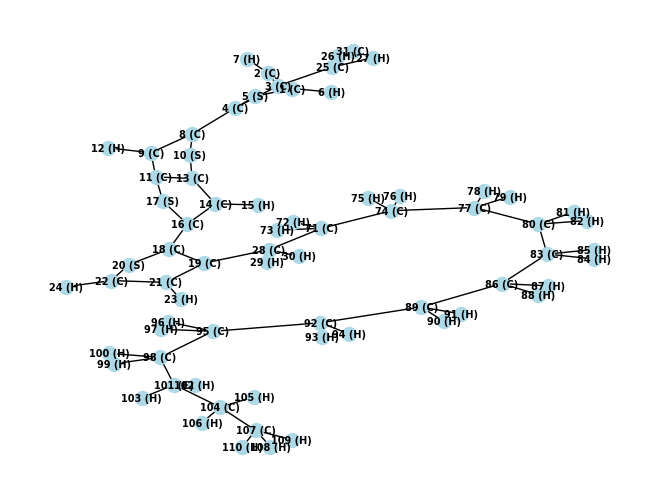

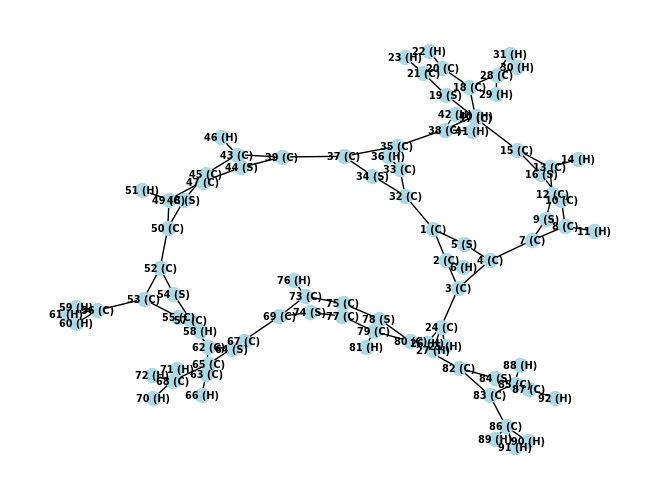

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Ensure 'nr' and 'in_sc' are strings in df1_atoms
df1_atoms['nr'] = df1_atoms['nr'].astype(str)
df1_atoms['in_sc'] = df1_atoms['in_sc'].astype(str)

# Ensure all values in df1_bonds are strings
df1_bonds['ai'] = df1_bonds['ai'].astype(str)
df1_bonds['aj'] = df1_bonds['aj'].astype(str)

# Create the graph and name it G_df1
G_df1 = nx.Graph()

# Add edges and nodes with labels
for _, row in df1_bonds.iterrows():
    ai, aj = row['ai'], row['aj']
    ai_label = f"{ai} ({row['ai_atom']})"
    aj_label = f"{aj} ({row['aj_atom']})"
    G_df1.add_edge(ai_label, aj_label)

# Identify vertices to remove based on 'nr' values where in_sc=1
nr_to_remove = df1_atoms[df1_atoms['in_sc'] == '1']['nr'].tolist()

# Convert to vertex labels in the graph (like '4 (Cl)')
vertices_to_remove = [f"{nr} ({row['ai_atom']})" for nr in nr_to_remove for _, row in df1_bonds.iterrows() if row['ai'] == nr or row['aj'] == nr]

# Remove the identified vertices and any connected edges from G_df1
G_df1.remove_nodes_from(vertices_to_remove)

# Draw the modified graph with labels
pos = nx.spring_layout(G_df1)
nx.draw(G_df1, pos, with_labels=True, node_color='lightblue', node_size=100, font_size=7, font_weight='bold')
plt.show()

# Create the graph and name it G_df3
G_df3 = nx.Graph()

# Add edges and nodes with labels
for _, row in df3_bonds.iterrows():
    ai, aj = row['ai'], row['aj']
    ai_label = f"{ai} ({row['ai_atom']})"
    aj_label = f"{aj} ({row['aj_atom']})"
    G_df3.add_edge(ai_label, aj_label)

# Draw the graph with labels
pos = nx.spring_layout(G_df3)
nx.draw(G_df3, pos, with_labels=True, node_color='lightblue', node_size=100, font_size=7, font_weight='bold')
plt.show()

In [ ]:
# Create a set of 'nr' values where 'in_sc' is not 0
nr_in_sc_not_zero = set(df3_atoms[df3_atoms['in_sc'] != 0]['nr'])

# Display the set of 'nr' values where 'in_sc' is not 0
print(nr_in_sc_not_zero)

{'60', '29', '72', '25', '42', '91'}


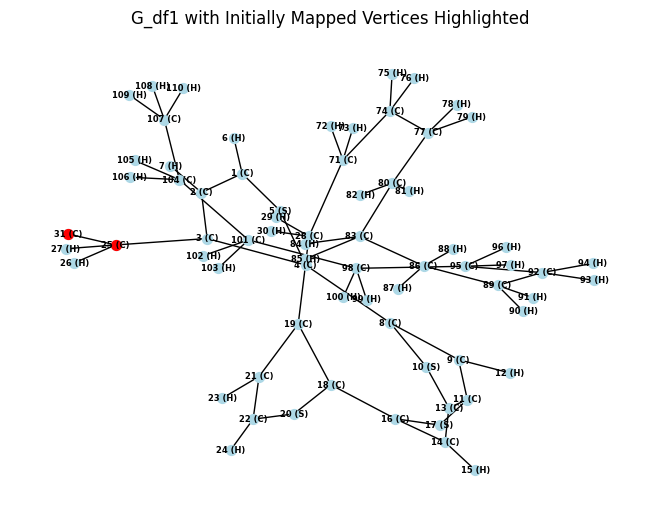

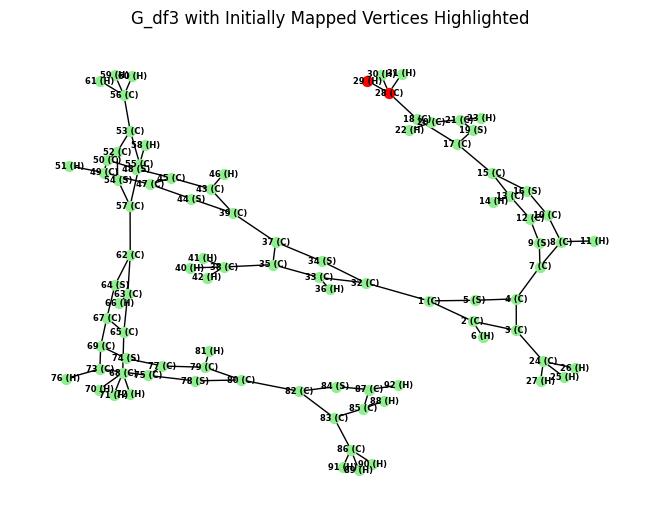

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to get node label from the graph based on vertex number
def get_node_label(graph, vertex_number):
    """Retrieve the node label from the graph based on the vertex number."""
    for node in graph.nodes():
        if node.startswith(f'{vertex_number} '):  # Check if the node starts with the vertex number
            return node
    raise KeyError(f"Node with number {vertex_number} not found in the graph.")

# Assume `sidechain_bond1` and `sidechain_bonds3` are available lists of sidechain bonds
# Automatically create the initial mapping from the first edge of each sidechain bond list
initial_mapping = {
    get_node_label(G_df1, sidechain_bond1[0][0]): get_node_label(G_df3, sidechain_bonds3[0][0]),
    get_node_label(G_df1, sidechain_bond1[0][1]): get_node_label(G_df3, sidechain_bonds3[0][1])
}

# Visualize G_df1 with initial mapped vertices in red
pos_df1 = nx.spring_layout(G_df1)  # Create a layout for the graph
highlight_vertices_df1 = list(initial_mapping.keys())  # Get the initially mapped vertices from G_df1

# Draw the entire graph first
nx.draw(G_df1, pos_df1, with_labels=True, node_color='lightblue', node_size=50, font_size=6, font_weight='bold')

# Highlight the initially mapped vertices in red
nx.draw_networkx_nodes(G_df1, pos_df1, nodelist=highlight_vertices_df1, node_color='red', node_size=50)

plt.title("G_df1 with Initially Mapped Vertices Highlighted")
plt.show()

# Visualize G_df3 with initial mapped vertices in red
pos_df3 = nx.spring_layout(G_df3)  # Create a layout for the graph
highlight_vertices_df3 = list(initial_mapping.values())  # Get the initially mapped vertices from G_df3

# Draw the entire graph first
nx.draw(G_df3, pos_df3, with_labels=True, node_color='lightgreen', node_size=50, font_size=6, font_weight='bold')

# Highlight the initially mapped vertices in red
nx.draw_networkx_nodes(G_df3, pos_df3, nodelist=highlight_vertices_df3, node_color='red', node_size=50)

plt.title("G_df3 with Initially Mapped Vertices Highlighted")
plt.show()


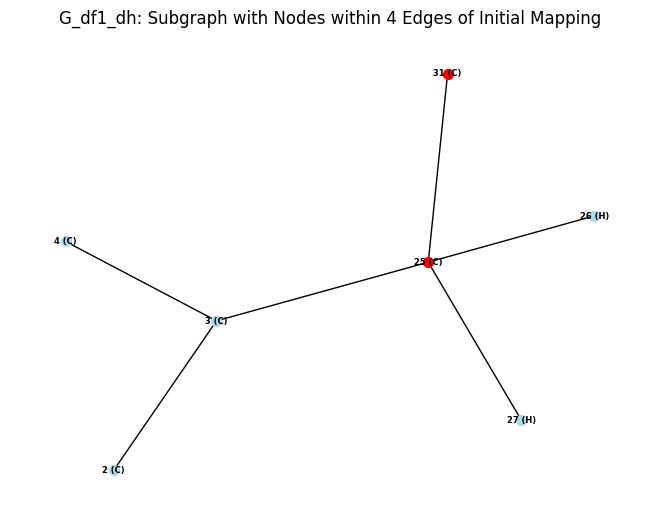

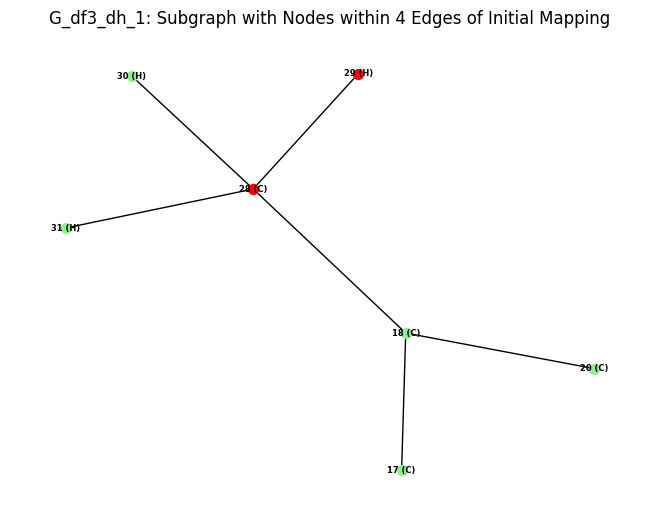

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to get node label from the graph based on vertex number
def get_node_label(graph, vertex_number):
    """Retrieve the node label from the graph based on the vertex number."""
    for node in graph.nodes():
        if node.startswith(f'{vertex_number} '):  # Check if the node starts with the vertex number
            return node
    raise KeyError(f"Node with number {vertex_number} not found in the graph.")

# Function to get all nodes within a certain distance (using BFS)
def get_nodes_within_distance(graph, starting_nodes, max_distance):
    """Return all nodes within `max_distance` edges from the starting nodes."""
    subgraph_nodes = set()
    for start_node in starting_nodes:
        # Perform a breadth-first search to get nodes within the max distance
        nodes_within_distance = nx.single_source_shortest_path_length(graph, start_node, cutoff=max_distance)
        subgraph_nodes.update(nodes_within_distance.keys())  # Add the nodes to the set
    return subgraph_nodes

# Assume `sidechain_bond1` and `sidechain_bonds3` are available lists of sidechain bonds
# Automatically create the initial mapping from the first edge of each sidechain bond list
initial_mapping = {
    get_node_label(G_df1, sidechain_bond1[0][0]): get_node_label(G_df3, sidechain_bonds3[0][0]),
    get_node_label(G_df1, sidechain_bond1[0][1]): get_node_label(G_df3, sidechain_bonds3[0][1])
}

# Step 1: Create a subgraph of G_df1 that contains only vertices within 4 edges from the initial mapping
highlight_vertices_df1 = list(initial_mapping.keys())  # Get the initially mapped vertices from G_df1
subgraph_nodes_df1 = get_nodes_within_distance(G_df1, highlight_vertices_df1, max_distance=2)

# Create the subgraph G_df1_dh with only the nodes within 4 edges
G_df1_dh = G_df1.subgraph(subgraph_nodes_df1).copy()

# Visualize the subgraph G_df1_dh
pos_df1_dh = nx.spring_layout(G_df1_dh)
nx.draw(G_df1_dh, pos_df1_dh, with_labels=True, node_color='lightblue', node_size=50, font_size=6, font_weight='bold')
nx.draw_networkx_nodes(G_df1_dh, pos_df1_dh, nodelist=highlight_vertices_df1, node_color='red', node_size=50)
plt.title("G_df1_dh: Subgraph with Nodes within 4 Edges of Initial Mapping")
plt.show()

# Step 2: Create a subgraph of G_df3 that contains only vertices within 4 edges from the initial mapping
highlight_vertices_df3 = list(initial_mapping.values())  # Get the initially mapped vertices from G_df3
subgraph_nodes_df3 = get_nodes_within_distance(G_df3, highlight_vertices_df3, max_distance=2)

# Create the subgraph G_df3_dh_1 with only the nodes within 4 edges
G_df3_dh_1 = G_df3.subgraph(subgraph_nodes_df3).copy()

# Visualize the subgraph G_df3_dh_1
pos_df3_dh_1 = nx.spring_layout(G_df3_dh_1)
nx.draw(G_df3_dh_1, pos_df3_dh_1, with_labels=True, node_color='lightgreen', node_size=50, font_size=6, font_weight='bold')
nx.draw_networkx_nodes(G_df3_dh_1, pos_df3_dh_1, nodelist=highlight_vertices_df3, node_color='red', node_size=50)
plt.title("G_df3_dh_1: Subgraph with Nodes within 4 Edges of Initial Mapping")
plt.show()


Best Overall Mapping from G_df1_dh to G_df3_dh_1:
25 (C) -> 28 (C)
31 (C) -> 29 (H)
27 (H) -> 31 (H)
3 (C) -> 18 (C)
4 (C) -> 20 (C)
26 (H) -> 30 (H)
Best Score: 4.5


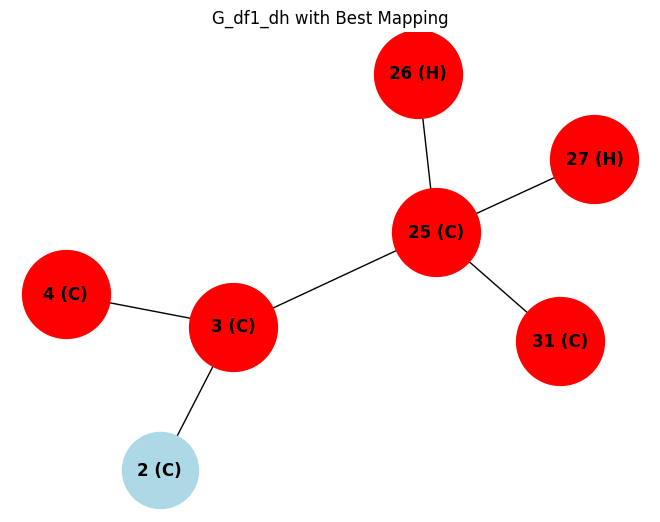

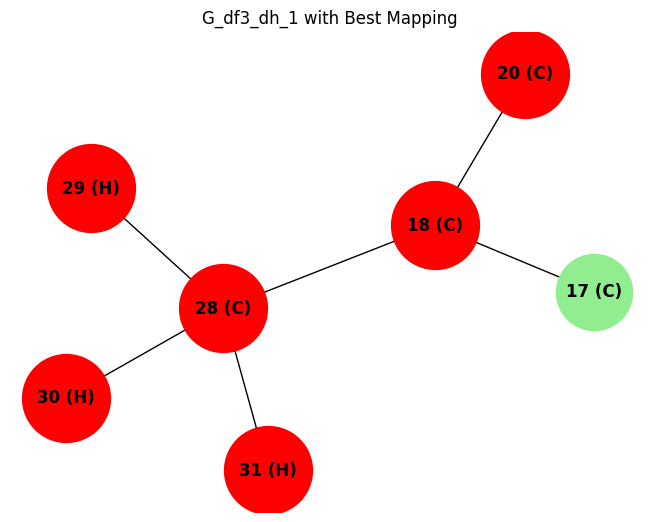

In [ ]:
import networkx as nx
import itertools

def enhanced_scoring_function(mapping, G1, G2):
    """Calculate a score for a given mapping based on the number of matching edges."""
    score = 0

    # Count how many edges are matched
    for edge1 in G1.edges():
        v1_1, v1_2 = edge1
        if v1_1 in mapping and v1_2 in mapping:
            mapped_edge = (mapping[v1_1], mapping[v1_2])
            if mapped_edge in G2.edges() or (mapped_edge[::-1] in G2.edges()):
                score += 1

    # Reward mappings that leave fewer vertices unmapped
    unmatched_vertices = len(G1.nodes()) - len(mapping)
    score -= unmatched_vertices * 0.5  # Adjust this weight as needed

    return score

def is_valid_mapping(v1, v2, mapping, G1, G2, initial_mapping, cache):
    """Check if adding a mapping (v1 -> v2) maintains the structure of the graphs."""
    if (v1, v2) in cache:
        return cache[(v1, v2)]

    if v1 not in initial_mapping and not match_vertices(v1, v2):
        cache[(v1, v2)] = False
        return False

    for neighbor in G1.neighbors(v1):
        if neighbor in mapping:
            mapped_neighbor = mapping[neighbor]
            if not G2.has_edge(v2, mapped_neighbor) and not G2.has_edge(mapped_neighbor, v2):
                cache[(v1, v2)] = False
                return False

    cache[(v1, v2)] = True
    return True

def find_best_fit(G1, G2, initial_mapping, depth_limit=4):
    """Find the best overall fit using a more flexible mapping approach with depth limit."""
    best_mapping = {}
    best_score = float('-inf')

    vertices_to_map = [v for v in G1.nodes() if v not in initial_mapping]
    cache = {}  # Cache for validity checks

    def backtrack(mapping, depth):
        nonlocal best_mapping, best_score

        # Stop recursion if we reach the depth limit
        if depth > depth_limit:
            return

        current_score = enhanced_scoring_function(mapping, G1, G2)
        if current_score > best_score:
            best_mapping = mapping.copy()
            best_score = current_score

        if len(mapping) == len(G1.nodes()):
            return

        for v1 in vertices_to_map:
            if v1 in mapping:
                continue

            potential_matches = [v2 for v2 in G2.nodes() if v2 not in mapping.values() and match_vertices(v1, v2)]
            for v2 in potential_matches:
                if is_valid_mapping(v1, v2, mapping, G1, G2, initial_mapping, cache):
                    mapping[v1] = v2
                    backtrack(mapping, depth + 1)
                    del mapping[v1]

    # Start backtracking with initial mapping and depth 0
    backtrack(initial_mapping.copy(), 0)
    return best_mapping, best_score

def match_vertices(v1, v2):
    """Check if two vertices (atoms) match based on their type."""
    return v1.split()[1] == v2.split()[1]  # Compare only the atom type, ignore the vertex number

def get_node_label(graph, vertex_number):
    """Retrieve the node label from the graph based on the vertex number."""
    for node in graph.nodes():
        if node.startswith(f'{vertex_number} '):  # Check if the node starts with the vertex number
            return node
    raise KeyError(f"Node with number {vertex_number} not found in the graph.")

# Automatically create the initial mapping from the first edge of each sidechain bond list
initial_mapping = {
    get_node_label(G_df1_dh, sidechain_bond1[0][0]): get_node_label(G_df3_dh_1, sidechain_bonds3[0][0]),
    get_node_label(G_df1_dh, sidechain_bond1[0][1]): get_node_label(G_df3_dh_1, sidechain_bonds3[0][1])
}

# Find the best overall fit with depth limited to 4
best_mapping, best_score = find_best_fit(G_df1_dh, G_df3_dh_1, initial_mapping, depth_limit=4)

# Display the best mapping
print("Best Overall Mapping from G_df1_dh to G_df3_dh_1:")
for v1, v2 in best_mapping.items():
    print(f"{v1} -> {v2}")

print(f"Best Score: {best_score}")

# Visualize the best mapping in G_df1_dh and G_df3_dh_1
highlight_vertices_df1 = list(best_mapping.keys())
highlight_vertices_df3 = list(best_mapping.values())

# G_df1_dh visualization
pos_df1 = nx.spring_layout(G_df1_dh)
nx.draw(G_df1_dh, pos_df1, with_labels=True, node_color='lightblue', node_size=3000, font_size=12, font_weight='bold')
nx.draw_networkx_nodes(G_df1_dh, pos_df1, nodelist=highlight_vertices_df1, node_color='red', node_size=4000)
plt.title("G_df1_dh with Best Mapping")
plt.show()

# G_df3 visualization
pos_df3 = nx.spring_layout(G_df3_dh_1)
nx.draw(G_df3_dh_1, pos_df3, with_labels=True, node_color='lightgreen', node_size=3000, font_size=12, font_weight='bold')
nx.draw_networkx_nodes(G_df3_dh_1, pos_df3, nodelist=highlight_vertices_df3, node_color='red', node_size=4000)
plt.title("G_df3_dh_1 with Best Mapping")
plt.show()

In [ ]:
# Convert the mapping to a dataframe
mapping_df = pd.DataFrame(list(best_mapping.items()), columns=['G_df1_vertex', 'G_df3_vertex'])

# Extract only the integer portion of the vertex labels
mapping_df['G_df1_vertex'] = mapping_df['G_df1_vertex'].apply(lambda x: int(x.split()[0]))
mapping_df['G_df3_vertex'] = mapping_df['G_df3_vertex'].apply(lambda x: int(x.split()[0]))

# Display the modified dataframe
print(mapping_df)

   G_df1_vertex  G_df3_vertex
0            25            28
1            31            29
2            27            31
3             3            18
4             4            20
5            26            30


In [ ]:
# Convert the mapping dictionary into a list of tuples for DataFrame creation
mapping_list = [(k, v) for k, v in best_mapping1.items()]

# Create the DataFrame with columns G_df1_vertex and G_df3_vertex
mapping_df1 = pd.DataFrame(mapping_list, columns=['G_df1_vertex', 'G_df3_vertex'])

# Convert the mapping dictionary into a list of tuple for DataFrame creation
mapping_list = [(k, v) for k, v in best_mapping2.items()]

# Create the DataFrame with columns G_df1_vertex and G_df3_vertex
mapping_df2 = pd.DataFrame(mapping_list, columns=['G_df1_vertex', 'G_df3_vertex'])

mapping_list = [(k, v) for k, v in best_mapping3.items()]

mapping_df3 = pd.DataFrame(mapping_list, columns=['G_df1_vertex', 'G_df3_vertex'])

mapping_list = [(k, v) for k, v in best_mapping4.items()]

mapping_df4 = pd.DataFrame(mapping_list, columns=['G_df1_vertex', 'G_df3_vertex'])

mapping_list = [(k, v) for k, v in best_mapping5.items()]

mapping_df5 = pd.DataFrame(mapping_list, columns=['G_df1_vertex', 'G_df3_vertex'])

mapping_list = [(k, v) for k, v in best_mapping6.items()]

mapping_df6 = pd.DataFrame(mapping_list, columns=['G_df1_vertex', 'G_df3_vertex'])

print(mapping_df1)
print(mapping_df2)
print(mapping_df3)
print(mapping_df4)
print(mapping_df5)
print(mapping_df6)

NameError: name 'best_mapping1' is not defined

## Building n-mer itp

In [ ]:
def filter_dataframe(df, nr_set):
    # Convert all values to strings to ensure consistent filtering
    df = df.astype(str)

    # Check if the columns exist before filtering
    columns_to_check = ['nr', 'ai', 'aj', 'ak', 'al']
    columns_in_df = [col for col in columns_to_check if col in df.columns]

    # Filter out rows where any of the columns have a value in nr_set
    filtered_df = df[~df[columns_in_df].isin(nr_set).any(axis=1)]
    return filtered_df

# Apply the filter function to each dataframe
df3_atoms_fin = filter_dataframe(df3_atoms, nr_in_sc_not_zero)
df3_bonds_fin = filter_dataframe(df3_bonds, nr_in_sc_not_zero)
df3_angles_fin = filter_dataframe(df3_angles, nr_in_sc_not_zero)
df3_proper_fin = filter_dataframe(df3_proper, nr_in_sc_not_zero)
df3_improper_fin = filter_dataframe(df3_improper, nr_in_sc_not_zero)

# Extract the 'type' column from the removed rows in df3_atoms
removed_types = set(df3_atoms.loc[~df3_atoms.index.isin(df3_atoms_fin.index), 'type'])

# Remove rows from df3_atomtypes where 'name' matches any of the removed 'type' values
df3_atomtypes_fin = df3_atomtypes[~df3_atomtypes['name'].isin(removed_types)]

# Display the resulting dataframes
print("Filtered df3_atoms:")
print(df3_atoms_fin)

print("\nFiltered df3_bonds:")
print(df3_bonds_fin)

print("\nFiltered df3_angles:")
print(df3_angles_fin)

print("\nFiltered df3_proper:")
print(df3_proper_fin)

print("\nFiltered df3_improper:")
print(df3_improper_fin)

print("\nFiltered df3_atomtypes:")
print(df3_atomtypes_fin)


Filtered df3_atoms:
    nr      type resnr residue cgnr   charge     mass atom_name atom_namnum  \
0    1  opls_800     1     UNK    1  -0.0763  12.0110         C          00   
1    2  opls_801     1     UNK    1  -0.1483  12.0110         C          01   
2    3  opls_802     1     UNK    1  -0.0641  12.0110         C          02   
3    4  opls_803     1     UNK    1  -0.0890  12.0110         C          03   
4    5  opls_804     1     UNK    1   0.0801  32.0600         S          04   
..  ..       ...   ...     ...  ...      ...      ...       ...         ...   
86  87  opls_886     1     UNK    3  -0.2210  12.0110         C          2G   
87  88  opls_887     1     UNK    3   0.1774   1.0080         H          2H   
88  89  opls_888     1     UNK    3   0.0997   1.0080         H          2I   
90  91  opls_890     1     UNK    3   0.0997   1.0080         H          2K   
91  92  opls_891     1     UNK    3   0.1967   1.0080         H          2M   

   in_sc  
0      0  
1      0 

In [ ]:
# Step 1: Measure the data type of the 'nr' column
original_dtype = df3_atoms['nr'].dtype

# Step 2: Convert the 'nr' column to integers
df3_atoms['nr'] = df3_atoms['nr'].astype(int)

# Calculate the maximum value of the 'nr' column
max_nr_value = df3_atoms['nr'].max()

# Step 3: Convert the 'nr' column back to its original data type
df3_atoms['nr'] = df3_atoms['nr'].astype(original_dtype)


## Renumbering sidechain dataframe in accordance to new mapping

In [ ]:
def renumber_dataframe(df, mapping_df):
    # Convert all values to strings in both the dataframe and the mapping_df
    df = df.astype(str)
    mapping_df = mapping_df.astype(str)

    # Create a mapping dictionary from G_df1_vertex to G_df3_vertex
    mapping_dict = mapping_df.set_index('G_df1_vertex')['G_df3_vertex'].to_dict()

    # Columns to check and renumber
    columns_to_check = ['nr', 'ai', 'aj', 'ak', 'al']
    columns_in_df = [col for col in columns_to_check if col in df.columns]

    # Process each column independently to avoid interference
    for col in columns_in_df:
        def renumber_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                return f"{value}*"  # Add * to values not in G_df1_vertex

        # Apply renumbering
        df[col] = df[col].apply(renumber_value)

    return df

# Apply the renumbering function to each df_sc dataframe
df_sc_atoms_fin = renumber_dataframe(df_sc_atoms, mapping_df6)
df_sc_bonds_fin = renumber_dataframe(df_sc_bonds, mapping_df6)
df_sc_angles_fin = renumber_dataframe(df_sc_angles, mapping_df6)
df_sc_proper_fin = renumber_dataframe(df_sc_proper, mapping_df6)
df_sc_improper_fin = renumber_dataframe(df_sc_improper, mapping_df6)

# Display the resulting dataframes
print("Renumbered df_sc_atoms:")
print(df_sc_atoms_fin)

print("\nRenumbered df_sc_bonds:")
print(df_sc_bonds_fin)

print("\nRenumbered df_sc_angles:")
print(df_sc_angles_fin)

print("\nRenumbered df_sc_proper:")
print(df_sc_proper_fin)

print("\nRenumbered df_sc_improper:")
print(df_sc_improper_fin)

Renumbered df_sc_atoms:
     nr       type resnr residue cgnr                charge     mass  \
0   11*  opls_0000     1     UNK    1  -0.17487130858011254  12.0110   
1   12*  opls_0001     1     UNK    1    0.0980411796114511   1.0080   
2   13*  opls_0002     1     UNK    1    0.0980411796114511   1.0080   
3   14*  opls_0003     1     UNK    1    -0.180769160471516  12.0110   
4   15*  opls_0004     1     UNK    1   0.09387137840391013   1.0080   
5   16*  opls_0005     1     UNK    1   0.09387137840391013   1.0080   
6   17*  opls_0006     1     UNK    1   -0.1818504333182733  12.0110   
7   18*  opls_0007     1     UNK    1   0.09427818827781657   1.0080   
8   19*  opls_0008     1     UNK    1   0.09427818827781657   1.0080   
9   20*  opls_0009     1     UNK    1  -0.18008107775085225  12.0110   
10  21*  opls_0010     1     UNK    1   0.09265094878219082   1.0080   
11  22*  opls_0011     1     UNK    1   0.09265094878219082   1.0080   
12  23*  opls_0012     1     UNK    1   

## Fixing atomtypes for new atoms added with sidechains

In [ ]:
# Reindex the df_sc_atoms DataFrame
df_sc_atoms = df_sc_atoms.reset_index(drop=True)

# Display the reindexed df_sc_atoms
print("Reindexed df_sc_atoms:")
print(df_sc_atoms)

Reindexed df_sc_atoms:
    nr       type resnr residue cgnr                charge     mass atom_name  \
0   11  opls_0000     1     UNK    1  -0.17487130858011254  12.0110         C   
1   12  opls_0001     1     UNK    1    0.0980411796114511   1.0080         H   
2   13  opls_0002     1     UNK    1    0.0980411796114511   1.0080         H   
3   14  opls_0003     1     UNK    1    -0.180769160471516  12.0110         C   
4   15  opls_0004     1     UNK    1   0.09387137840391013   1.0080         H   
5   16  opls_0005     1     UNK    1   0.09387137840391013   1.0080         H   
6   17  opls_0006     1     UNK    1   -0.1818504333182733  12.0110         C   
7   18  opls_0007     1     UNK    1   0.09427818827781657   1.0080         H   
8   19  opls_0008     1     UNK    1   0.09427818827781657   1.0080         H   
9   20  opls_0009     1     UNK    1  -0.18008107775085225  12.0110         C   
10  21  opls_0010     1     UNK    1   0.09265094878219082   1.0080         H   
11  2

In [ ]:
# Step 1: Ensure that both columns are strings
df_sc_atoms['type'] = df_sc_atoms['type'].astype(str)
df_sc_atomtypes['name'] = df_sc_atomtypes['name'].astype(str)

# Step 2: Reorder df_sc_atomtypes to match the order of 'type' in df_sc_atoms
df_sc_atomtypes = df_sc_atomtypes.set_index('name').reindex(df_sc_atoms['type']).reset_index()

# Step 3: Reindex the reordered df_sc_atomtypes
df_sc_atomtypes = df_sc_atomtypes.reset_index(drop=True)

# Display the reordered and reindexed df_sc_atomtypes
print("Reordered and Reindexed df_sc_atomtypes:")
print(df_sc_atomtypes)

Reordered and Reindexed df_sc_atomtypes:
         type bond_type     mass charge ptype        sigma      epsilon
0   opls_0000      C810  12.0110  0.000     A  3.50000E-01  2.76144E-01
1   opls_0001      H811   1.0080  0.000     A  2.50000E-01  1.25520E-01
2   opls_0002      H812   1.0080  0.000     A  2.50000E-01  1.25520E-01
3   opls_0003      C813  12.0110  0.000     A  3.50000E-01  2.76144E-01
4   opls_0004      H814   1.0080  0.000     A  2.50000E-01  1.25520E-01
5   opls_0005      H815   1.0080  0.000     A  2.50000E-01  1.25520E-01
6   opls_0006      C816  12.0110  0.000     A  3.50000E-01  2.76144E-01
7   opls_0007      H817   1.0080  0.000     A  2.50000E-01  1.25520E-01
8   opls_0008      H818   1.0080  0.000     A  2.50000E-01  1.25520E-01
9   opls_0009      C819  12.0110  0.000     A  3.50000E-01  2.76144E-01
10  opls_0010      H820   1.0080  0.000     A  2.50000E-01  1.25520E-01
11  opls_0011      H821   1.0080  0.000     A  2.50000E-01  1.25520E-01
12  opls_0012      C822

In [ ]:
# Generate new names for the 'type' column in the format 'opls_0000', 'opls_0001', etc.
df_sc_atoms['type'] = ['opls_{:04d}'.format(i) for i in range(len(df_sc_atoms))]
df_sc_atomtypes['type'] = ['opls_{:04d}'.format(i) for i in range(len(df_sc_atoms))]

# Display the updated df_sc_atoms
print("Updated df_sc_atoms with renamed 'type' column:")
print(df_sc_atoms)

print("Updated df_sc_atomtypes with renamed 'type' column:")
print(df_sc_atomtypes)

Updated df_sc_atoms with renamed 'type' column:
    nr       type resnr residue cgnr                charge     mass atom_name  \
0   11  opls_0000     1     UNK    1  -0.17487130858011254  12.0110         C   
1   12  opls_0001     1     UNK    1    0.0980411796114511   1.0080         H   
2   13  opls_0002     1     UNK    1    0.0980411796114511   1.0080         H   
3   14  opls_0003     1     UNK    1    -0.180769160471516  12.0110         C   
4   15  opls_0004     1     UNK    1   0.09387137840391013   1.0080         H   
5   16  opls_0005     1     UNK    1   0.09387137840391013   1.0080         H   
6   17  opls_0006     1     UNK    1   -0.1818504333182733  12.0110         C   
7   18  opls_0007     1     UNK    1   0.09427818827781657   1.0080         H   
8   19  opls_0008     1     UNK    1   0.09427818827781657   1.0080         H   
9   20  opls_0009     1     UNK    1  -0.18008107775085225  12.0110         C   
10  21  opls_0010     1     UNK    1   0.09265094878219082   

## Fixing Sidechain itp nr's for new sidechain stoms

In [ ]:
# Convert the 'in_sc' column to a string
df1_atoms['in_sc'] = df1_atoms['in_sc'].astype(str)

# Filter the df1_atoms DataFrame to get rows where 'in_sc' is '1'
df1_atoms_modified = df1_atoms[df1_atoms['in_sc'] == '1']

# Display the filtered dataframe
print("Filtered df1_atoms with 'in_sc' == '1':")
print(df1_atoms_modified)

Filtered df1_atoms with 'in_sc' == '1':
    nr      type resnr residue cgnr   charge     mass atom_name atom_namnum  \
11  12  opls_811     1     UNK    1   0.0964   1.0080         H          0B   
12  13  opls_812     1     UNK    1   0.0964   1.0080         H          0C   
13  14  opls_813     1     UNK    1  -0.1839  12.0110         C          0D   
14  15  opls_814     1     UNK    1   0.0923   1.0080         H          0E   
15  16  opls_815     1     UNK    1   0.0923   1.0080         H          0F   
16  17  opls_816     1     UNK    1  -0.1850  12.0110         C          0G   
17  18  opls_817     1     UNK    1   0.0927   1.0080         H          0H   
18  19  opls_818     1     UNK    1   0.0927   1.0080         H          0I   
19  20  opls_819     1     UNK    1  -0.1832  12.0110         C          0J   
20  21  opls_820     1     UNK    1   0.0911   1.0080         H          0K   
21  22  opls_821     1     UNK    1   0.0911   1.0080         H          0M   
22  23  opls

In [ ]:
max_nr_valuemax_nr_value = df3_atoms_fin['nr'].max()
max_nr_valuemax_nr_value

'92'

In [ ]:
# Step 1: Reindex the df1_atoms_modified DataFrame
df1_atoms_modified = df1_atoms_modified.reset_index(drop=True)

# Step 2: Add the new column 'new_nr'
df1_atoms_modified['new_nr'] = df1_atoms_modified.index + max_nr_value + 1

# Display the updated df1_atoms_modified DataFrame
print("Updated df1_atoms_modified with new_nr column:")
print(df1_atoms_modified)


Updated df1_atoms_modified with new_nr column:
    nr      type resnr residue cgnr   charge     mass atom_name atom_namnum  \
0   12  opls_811     1     UNK    1   0.0964   1.0080         H          0B   
1   13  opls_812     1     UNK    1   0.0964   1.0080         H          0C   
2   14  opls_813     1     UNK    1  -0.1839  12.0110         C          0D   
3   15  opls_814     1     UNK    1   0.0923   1.0080         H          0E   
4   16  opls_815     1     UNK    1   0.0923   1.0080         H          0F   
5   17  opls_816     1     UNK    1  -0.1850  12.0110         C          0G   
6   18  opls_817     1     UNK    1   0.0927   1.0080         H          0H   
7   19  opls_818     1     UNK    1   0.0927   1.0080         H          0I   
8   20  opls_819     1     UNK    1  -0.1832  12.0110         C          0J   
9   21  opls_820     1     UNK    1   0.0911   1.0080         H          0K   
10  22  opls_821     1     UNK    1   0.0911   1.0080         H          0M   
11  2

In [ ]:
# Step 1: Ensure that all relevant columns are strings
def ensure_columns_are_strings(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype(str)
    return df

columns_to_check = ['nr', 'ai', 'aj', 'ak', 'al']

# Apply the conversion to string for each relevant dataframe
df_sc_atoms_fin = ensure_columns_are_strings(df_sc_atoms_fin, columns_to_check)
df_sc_bonds_fin = ensure_columns_are_strings(df_sc_bonds_fin, columns_to_check)
df_sc_angles_fin = ensure_columns_are_strings(df_sc_angles_fin, columns_to_check)
df_sc_improper_fin = ensure_columns_are_strings(df_sc_improper_fin, columns_to_check)
df_sc_proper_fin = ensure_columns_are_strings(df_sc_proper_fin, columns_to_check)

# Step 2: Create a dictionary to map old 'nr' values to 'new_nr' values
nr_to_new_nr_mapping = dict(zip(df1_atoms_modified['nr'].astype(str), df1_atoms_modified['new_nr'].astype(str)))

# Step 3: Function to replace matching values in the dataframe
def replace_nr_values(df, mapping, columns):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: mapping.get(x, x))  # Replace with new_nr if there's a match
    return df

# Apply the replacement function to each relevant dataframe
df_sc_atoms_fin = replace_nr_values(df_sc_atoms_fin, nr_to_new_nr_mapping, columns_to_check)
df_sc_bonds_fin = replace_nr_values(df_sc_bonds_fin, nr_to_new_nr_mapping, columns_to_check)
df_sc_angles_fin = replace_nr_values(df_sc_angles_fin, nr_to_new_nr_mapping, columns_to_check)
df_sc_improper_fin = replace_nr_values(df_sc_improper_fin, nr_to_new_nr_mapping, columns_to_check)
df_sc_proper_fin = replace_nr_values(df_sc_proper_fin, nr_to_new_nr_mapping, columns_to_check)

# Display the updated dataframes
print("Updated df_sc_atoms_fin:")
print(df_sc_atoms_fin)

print("\nUpdated df_sc_bonds_fin:")
print(df_sc_bonds_fin)

print("\nUpdated df_sc_angles_fin:")
print(df_sc_angles_fin)

print("\nUpdated df_sc_improper_fin:")
print(df_sc_improper_fin)

print("\nUpdated df_sc_proper_fin:")
print(df_sc_proper_fin)


Updated df_sc_atoms_fin:
     nr       type resnr residue cgnr                charge     mass  \
0   11*  opls_0000     1     UNK    1  -0.17487130858011254  12.0110   
1   12*  opls_0001     1     UNK    1    0.0980411796114511   1.0080   
2   13*  opls_0002     1     UNK    1    0.0980411796114511   1.0080   
3   14*  opls_0003     1     UNK    1    -0.180769160471516  12.0110   
4   15*  opls_0004     1     UNK    1   0.09387137840391013   1.0080   
5   16*  opls_0005     1     UNK    1   0.09387137840391013   1.0080   
6   17*  opls_0006     1     UNK    1   -0.1818504333182733  12.0110   
7   18*  opls_0007     1     UNK    1   0.09427818827781657   1.0080   
8   19*  opls_0008     1     UNK    1   0.09427818827781657   1.0080   
9   20*  opls_0009     1     UNK    1  -0.18008107775085225  12.0110   
10  21*  opls_0010     1     UNK    1   0.09265094878219082   1.0080   
11  22*  opls_0011     1     UNK    1   0.09265094878219082   1.0080   
12  23*  opls_0012     1     UNK    1  

In [ ]:
def remove_asterisk_rows(df):
    # Define a function to check if a value contains an asterisk
    def contains_asterisk(value):
        return '*' in value

    # Apply filtering to remove rows where any of the relevant columns contain an asterisk
    columns_to_check = ['nr', 'ai', 'aj', 'ak', 'al']
    columns_in_df = [col for col in columns_to_check if col in df.columns]

    # Filter the dataframe
    filtered_df = df[~df[columns_in_df].apply(lambda col: col.map(contains_asterisk)).any(axis=1)]

    return filtered_df

# Apply the removal function to each df_sc_fin dataframe
df_sc_atoms_fin = remove_asterisk_rows(df_sc_atoms_fin)
df_sc_bonds_fin = remove_asterisk_rows(df_sc_bonds_fin)
df_sc_angles_fin = remove_asterisk_rows(df_sc_angles_fin)
df_sc_improper_fin = remove_asterisk_rows(df_sc_improper_fin)
df_sc_proper_fin = remove_asterisk_rows(df_sc_proper_fin)

# Display the cleaned dataframes
print("Cleaned df_sc_atoms_fin:")
print(df_sc_atoms_fin)

print("\nCleaned df_sc_bonds_fin:")
print(df_sc_bonds_fin)

print("\nCleaned df_sc_angles_fin:")
print(df_sc_angles_fin)

print("\nCleaned df_sc_improper_fin:")
print(df_sc_improper_fin)

print("\nCleaned df_sc_proper_fin:")
print(df_sc_proper_fin)

Cleaned df_sc_atoms_fin:
Empty DataFrame
Columns: [nr, type, resnr, residue, cgnr, charge, mass, atom_name, atom_namnum]
Index: []

Cleaned df_sc_bonds_fin:
Empty DataFrame
Columns: [ai, aj, funct, b0, kb, ai_atom, aj_atom]
Index: []

Cleaned df_sc_angles_fin:
Empty DataFrame
Columns: [ai, aj, ak, funct, theta0, cth, ai_atom, aj_atom, ak_atom]
Index: []

Cleaned df_sc_improper_fin:
Empty DataFrame
Columns: [ai, aj, ak, al, funct, c0, c1, c2, ai_atom, aj_atom, ak_atom, al_atom]
Index: []

Cleaned df_sc_proper_fin:
Empty DataFrame
Columns: [ai, aj, ak, al, funct, c0, c1, c2, c3, c4, c5, ai_atom, aj_atom, ak_atom, al_atom]
Index: []


## Adding sidechain itp to n-mer itp

In [ ]:
# Rename the 'type' column to 'name' in df_sc_atomtypes
df_sc_atomtypes = df_sc_atomtypes.rename(columns={'type': 'name'})

# Display the updated df_sc_atomtypes DataFrame
print("Updated df_sc_atomtypes with 'type' renamed to 'name':")
print(df_sc_atomtypes)


Updated df_sc_atomtypes with 'type' renamed to 'name':
         name bond_type     mass charge ptype        sigma      epsilon
0   opls_0000      C810  12.0110  0.000     A  3.50000E-01  2.76144E-01
1   opls_0001      H811   1.0080  0.000     A  2.50000E-01  1.25520E-01
2   opls_0002      H812   1.0080  0.000     A  2.50000E-01  1.25520E-01
3   opls_0003      C813  12.0110  0.000     A  3.50000E-01  2.76144E-01
4   opls_0004      H814   1.0080  0.000     A  2.50000E-01  1.25520E-01
5   opls_0005      H815   1.0080  0.000     A  2.50000E-01  1.25520E-01
6   opls_0006      C816  12.0110  0.000     A  3.50000E-01  2.76144E-01
7   opls_0007      H817   1.0080  0.000     A  2.50000E-01  1.25520E-01
8   opls_0008      H818   1.0080  0.000     A  2.50000E-01  1.25520E-01
9   opls_0009      C819  12.0110  0.000     A  3.50000E-01  2.76144E-01
10  opls_0010      H820   1.0080  0.000     A  2.50000E-01  1.25520E-01
11  opls_0011      H821   1.0080  0.000     A  2.50000E-01  1.25520E-01
12  opls_

In [ ]:
# Append df_sc_fin dataframes to the corresponding df3_fin dataframes
df3_atomtypes_fin = pd.concat([df3_atomtypes_fin, df_sc_atomtypes], ignore_index=True)
df3_atoms_fin = pd.concat([df3_atoms_fin, df_sc_atoms_fin], ignore_index=True)
df3_bonds_fin = pd.concat([df3_bonds_fin, df_sc_bonds_fin], ignore_index=True)
df3_angles_fin = pd.concat([df3_angles_fin, df_sc_angles_fin], ignore_index=True)
df3_improper_fin = pd.concat([df3_improper_fin, df_sc_improper_fin], ignore_index=True)
df3_proper_fin = pd.concat([df3_proper_fin, df_sc_proper_fin], ignore_index=True)

# Display the updated dataframes
print("Updated df3_atomtypes_fin:")
print(df3_atomtypes_fin)

print("Updated df3_atoms_fin:")
print(df3_atoms_fin)

print("\nUpdated df3_bonds_fin:")
print(df3_bonds_fin)

print("\nUpdated df3_angles_fin:")
print(df3_angles_fin)

print("\nUpdated df3_improper_fin:")
print(df3_improper_fin)

print("\nUpdated df3_proper_fin:")
print(df3_proper_fin)


Updated df3_atomtypes_fin:
          name bond_type     mass charge ptype        sigma      epsilon
0     opls_866      C866  12.0110  0.000     A  3.55000E-01  2.92880E-01
1     opls_833      S833  32.0600  0.000     A  3.60000E-01  1.48532E+00
2     opls_870      H870   1.0080  0.000     A  2.50000E-01  1.25520E-01
3     opls_873      S873  32.0600  0.000     A  3.60000E-01  1.48532E+00
4     opls_828      H828   1.0080  0.000     A  2.50000E-01  1.25520E-01
..         ...       ...      ...    ...   ...          ...          ...
321  opls_0035      H845   1.0080  0.000     A  2.50000E-01  1.25520E-01
322  opls_0036      C846  12.0110  0.000     A  3.50000E-01  2.76144E-01
323  opls_0037      H847   1.0080  0.000     A  2.50000E-01  1.25520E-01
324  opls_0038      H848   1.0080  0.000     A  2.50000E-01  1.25520E-01
325  opls_0039      H849   1.0080  0.000     A  2.50000E-01  1.25520E-01

[326 rows x 7 columns]
Updated df3_atoms_fin:
    nr      type resnr residue cgnr   charge     m

# working

# Molecular Graph Isomorphism

In [ ]:
def match_vertices(v1, v2):
    """Check if two vertices (atoms) match based on their type."""
    return v1.split()[1] == v2.split()[1]

def match_edges(e1, e2, G1, G2):
    """Check if two edges (bonds) match based on their connected vertices."""
    v1_1, v1_2 = e1
    v2_1, v2_2 = e2
    return (match_vertices(G1.nodes[v1_1]['label'], G2.nodes[v2_1]['label']) and
            match_vertices(G1.nodes[v1_2]['label'], G2.nodes[v2_2]['label'])) or \
           (match_vertices(G1.nodes[v1_1]['label'], G2.nodes[v2_2]['label']) and
            match_vertices(G1.nodes[v1_2]['label'], G2.nodes[v2_1]['label']))
def find_isomorphism(G1, G2, initial_mapping):
    """Find a subgraph isomorphism between G1 and G2 starting from initial mapping."""
    mapping = initial_mapping.copy()

    for e1 in G1.edges():
        for e2 in G2.edges():
            if e1 not in mapping and match_edges(e1, e2, G1, G2):
                mapping[e1] = e2
                break

    return mapping

# Initialize the initial mapping with the matched vertices
initial_mapping = {sidechain_bond1[0][0]: sidechain_bonds3[0][0],
                   sidechain_bond1[0][1]: sidechain_bonds3[0][1]}

# Find the isomorphism
isomorphism_mapping = find_isomorphism(G_df1, G_df3, initial_mapping)

# Display the mapping
print("Isomorphism mapping from G_df1 to G_df3:")
print(isomorphism_mapping)

Isomorphism mapping from G_df1 to G_df3:
{1: 1, 4: 4, ('2 (H)', '1 (C)'): ('2 (H)', '1 (C)'), ('1 (C)', '3 (H)'): ('2 (H)', '1 (C)'), ('1 (C)', '5 (O)'): ('1 (C)', '5 (O)'), ('5 (O)', '6 (O)'): ('5 (O)', '6 (O)'), ('6 (O)', '7 (H)'): ('16 (O)', '17 (H)')}


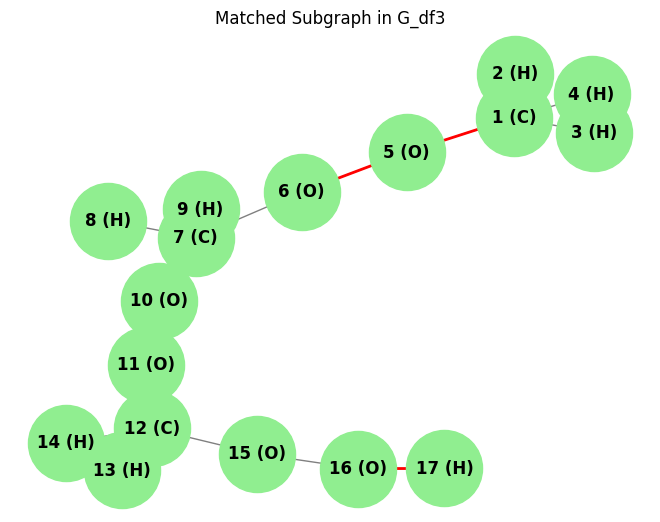

In [ ]:
# Visualize the matched subgraph in G_df3
matched_edges = [isomorphism_mapping[edge] for edge in G_df1.edges() if edge in isomorphism_mapping]

pos = nx.spring_layout(G_df3)
nx.draw(G_df3, pos, with_labels=True, node_color='lightgreen', node_size=3000, font_size=12, font_weight='bold', edge_color='gray')
nx.draw_networkx_edges(G_df3, pos, edgelist=matched_edges, edge_color='red', width=2)
plt.title("Matched Subgraph in G_df3")
plt.show()


# Graph Approach

Removing end hydrogen atom: 7
Removing start hydrogen atom: 4
Removing end hydrogen atom: 7
Removing start hydrogen atom: 4


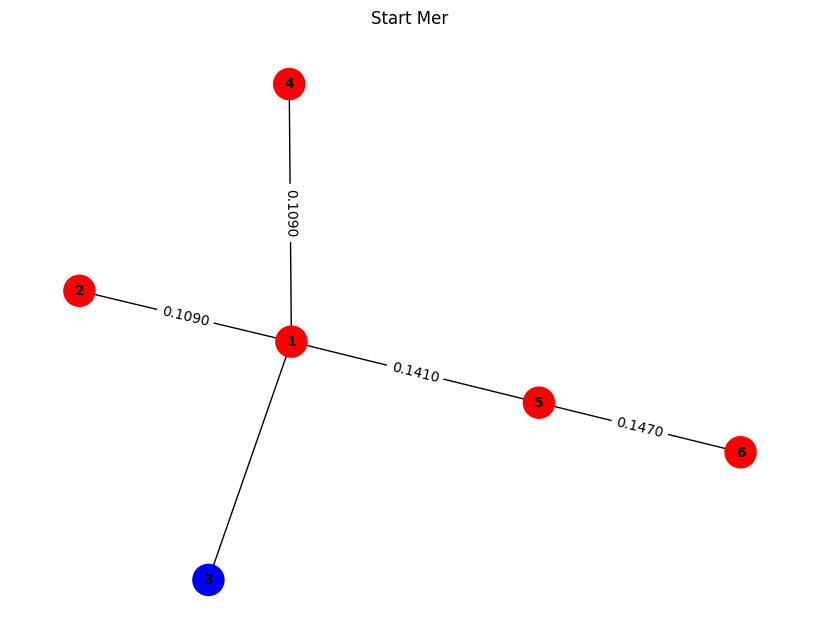

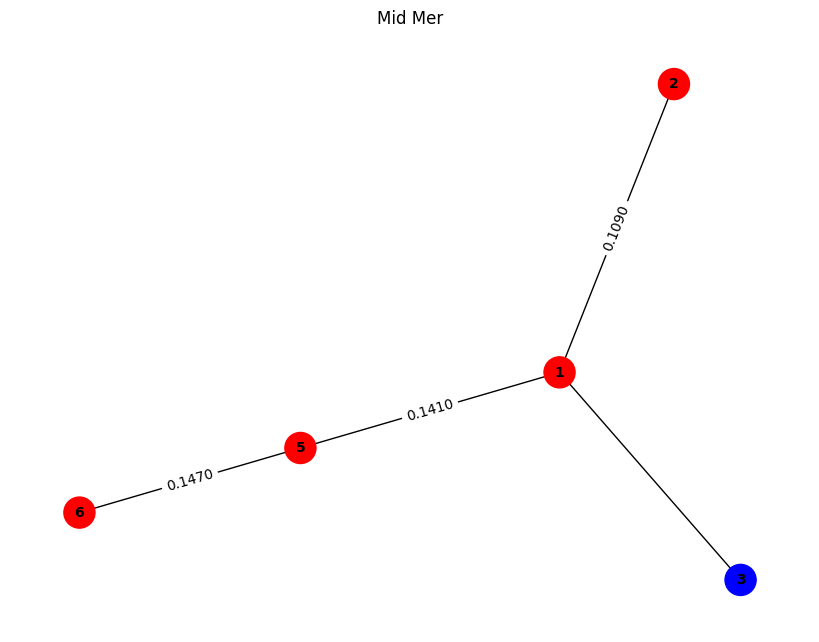

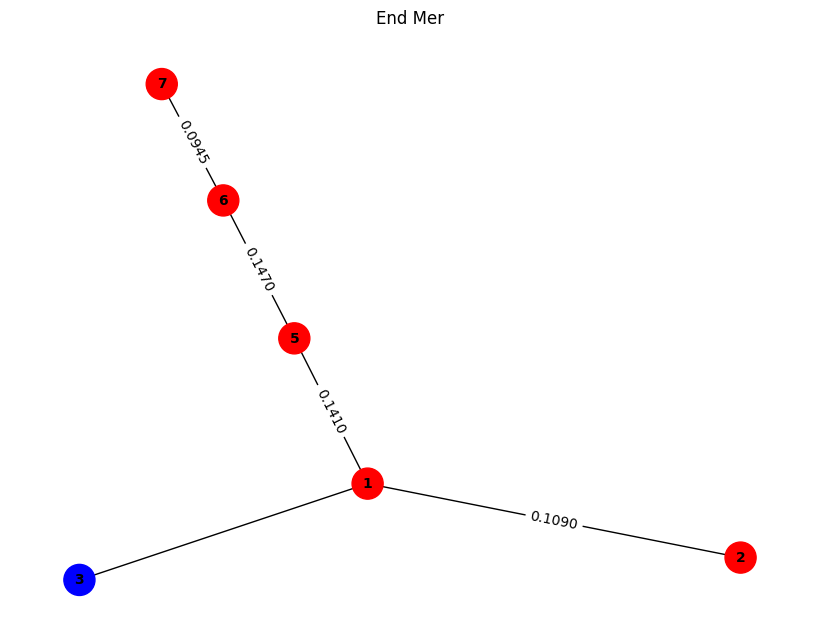

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Function to create a graph from the DataFrame
def bonds_to_graph(df_bonds):
    G = nx.Graph()
    for _, row in df_bonds.iterrows():
        G.add_edge(int(row['ai']), int(row['aj']), funct=row['funct'], b0=row['b0'], kb=row['kb'])
    return G

# Function to build the structure by removing specified hydrogen atoms
def build_structure(df_bonds, hydrogen_atoms, structure_type):
    """
    Build a structure based on the presence or absence of hydrogen atoms.
    :param df_bonds: DataFrame containing bond information.
    :param hydrogen_atoms: Tuple containing the start and end hydrogen atom numbers.
    :param structure_type: Type of structure ('start_mer', 'mid_mer', 'end_mer').
    :return: Modified graph.
    """
    start_hydrogen, end_hydrogen = hydrogen_atoms
    G = bonds_to_graph(df_bonds)

    if structure_type == 'start_mer':
        # Remove the end hydrogen atom and its associated edges
        if G.has_node(end_hydrogen):
            print(f"Removing end hydrogen atom: {end_hydrogen}")
            G.remove_node(end_hydrogen)
        else:
            print(f"End hydrogen atom {end_hydrogen} not found in the graph")
    elif structure_type == 'mid_mer':
        # Remove both start and end hydrogen atoms and their associated edges
        if G.has_node(start_hydrogen):
            print(f"Removing start hydrogen atom: {start_hydrogen}")
            G.remove_node(start_hydrogen)
        else:
            print(f"Start hydrogen atom {start_hydrogen} not found in the graph")
        if G.has_node(end_hydrogen):
            print(f"Removing end hydrogen atom: {end_hydrogen}")
            G.remove_node(end_hydrogen)
        else:
            print(f"End hydrogen atom {end_hydrogen} not found in the graph")
    elif structure_type == 'end_mer':
        # Remove the start hydrogen atom and its associated edges
        if G.has_node(start_hydrogen):
            print(f"Removing start hydrogen atom: {start_hydrogen}")
            G.remove_node(start_hydrogen)
        else:
            print(f"Start hydrogen atom {start_hydrogen} not found in the graph")

    return G

# Function to color the graph based on backbone and sidechain nodes
def color_graph(G, sidechain_bond):
    """
    Color the graph based on the backbone and sidechain nodes.
    :param G: Graph.
    :param sidechain_bond: List containing the nodes of the sidechain bond.
    :return: Color mapping for the graph nodes.
    """
    backbone_node, sidechain_node = map(int, sidechain_bond)

    # Temporarily remove the edge
    if G.has_edge(backbone_node, sidechain_node):
        G.remove_edge(backbone_node, sidechain_node)

    # Perform a BFS from the backbone_node to identify all backbone nodes
    backbone_nodes = set(nx.node_connected_component(G, backbone_node))

    # The remaining nodes are sidechain nodes
    sidechain_nodes = set(G.nodes()) - backbone_nodes

    # Re-add the edge
    G.add_edge(backbone_node, sidechain_node)

    # Color mapping
    color_map = []
    for node in G:
        if node in backbone_nodes:
            color_map.append('red')
        elif node in sidechain_nodes:
            color_map.append('blue')
        else:
            color_map.append('green')  # This should not happen

    return color_map

# Function to draw the graph with colored nodes
def draw_colored_graph(G, color_map, title):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'b0')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Example: Assume start_hydrogen is 4 and end_hydrogen is 7
start_hydrogen = 4
end_hydrogen = 7

# Example sidechain bond
sidechain_bond = ['1', '3']

# Build the structures
start_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'start_mer')
mid_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'mid_mer')
end_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'end_mer')

# Color the graphs
color_map_start = color_graph(start_mer, sidechain_bond)
color_map_mid = color_graph(mid_mer, sidechain_bond)
color_map_end = color_graph(end_mer, sidechain_bond)

# Draw the colored graphs
draw_colored_graph(start_mer, color_map_start, "Start Mer")
draw_colored_graph(mid_mer, color_map_mid, "Mid Mer")
draw_colored_graph(end_mer, color_map_end, "End Mer")

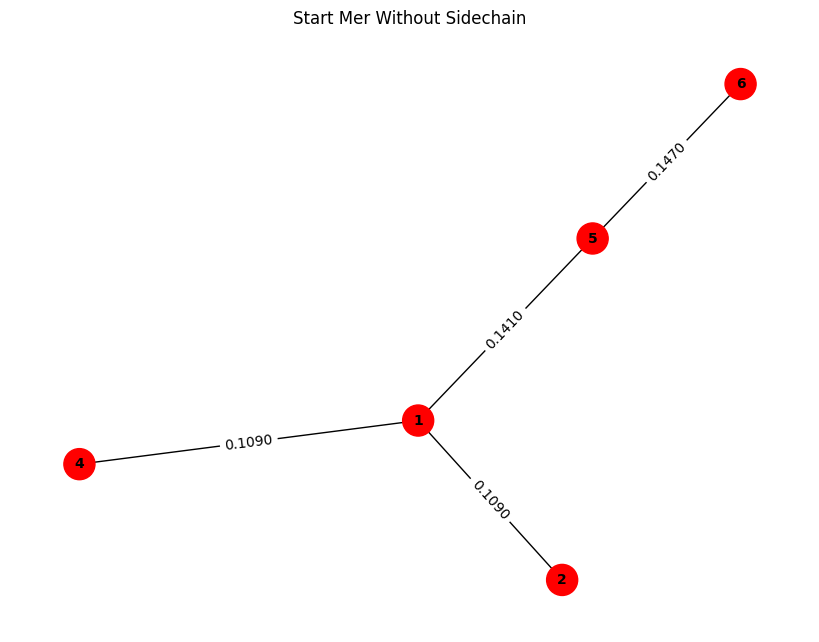

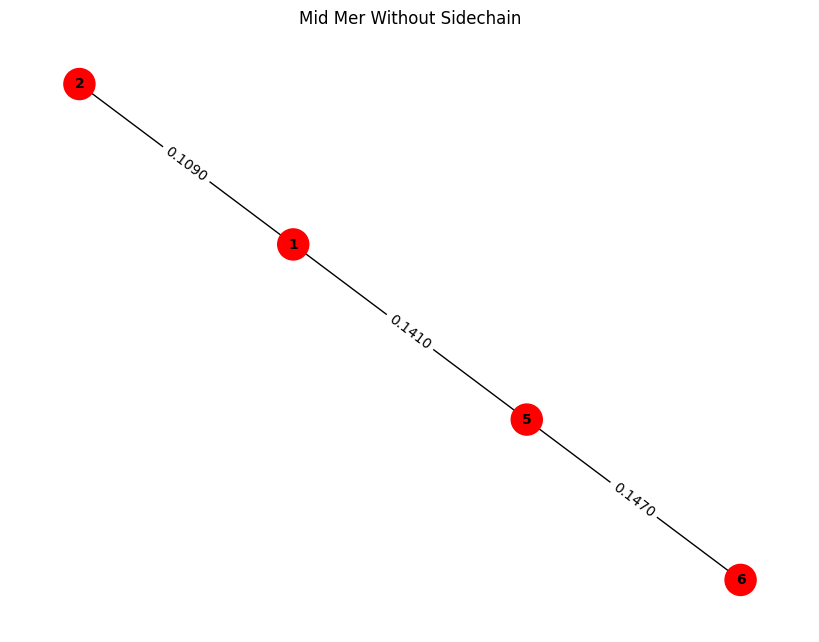

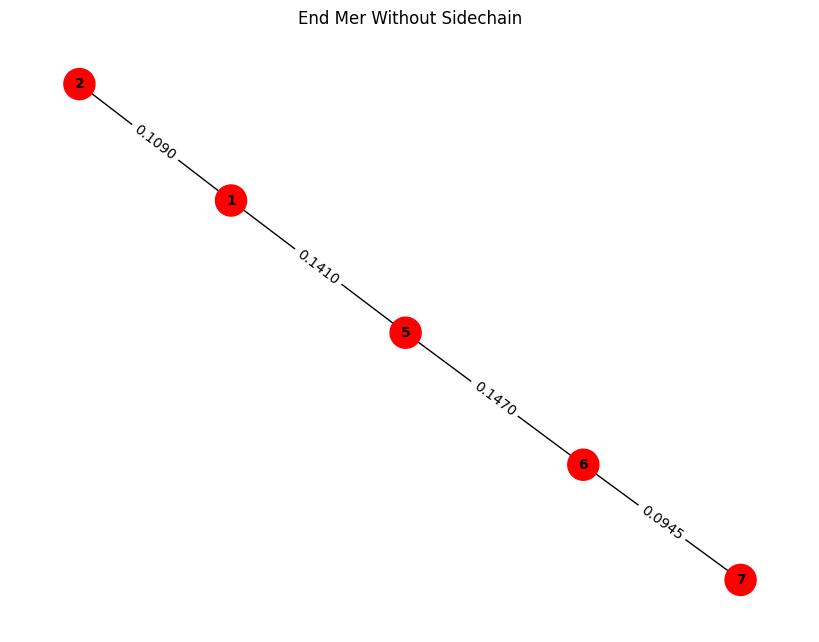

In [ ]:
# Function to remove sidechains and return the graph without sidechains
def remove_sidechains(G, sidechain_bond):
    backbone_node, sidechain_node = map(int, sidechain_bond)

    # Temporarily remove the edge to separate the backbone and sidechain
    if G.has_edge(backbone_node, sidechain_node):
        G.remove_edge(backbone_node, sidechain_node)

    # Perform BFS from the backbone_node to identify all backbone nodes
    backbone_nodes = set(nx.node_connected_component(G, backbone_node))

    # The remaining nodes are sidechain nodes
    sidechain_nodes = set(G.nodes()) - backbone_nodes

    # Remove sidechain nodes from the graph
    G.remove_nodes_from(sidechain_nodes)

    return G

# Example sidechain bond
sidechain_bond = ['1', '3']

# Remove sidechains from the structures
start_mer_no_sidechain = remove_sidechains(start_mer.copy(), sidechain_bond)
mid_mer_no_sidechain = remove_sidechains(mid_mer.copy(), sidechain_bond)
end_mer_no_sidechain = remove_sidechains(end_mer.copy(), sidechain_bond)

# Draw the graphs without sidechains
draw_colored_graph(start_mer_no_sidechain, ['red'] * len(start_mer_no_sidechain.nodes()), "Start Mer Without Sidechain")
draw_colored_graph(mid_mer_no_sidechain, ['red'] * len(mid_mer_no_sidechain.nodes()), "Mid Mer Without Sidechain")
draw_colored_graph(end_mer_no_sidechain, ['red'] * len(end_mer_no_sidechain.nodes()), "End Mer Without Sidechain")

The small graph is a subgraph of the big graph
Mapping of nodes: {2: 2, 1: 1, 3: 4, 5: 5, 6: 6}
Vertices of G that have been mapped: {1, 2, 4, 5, 6}


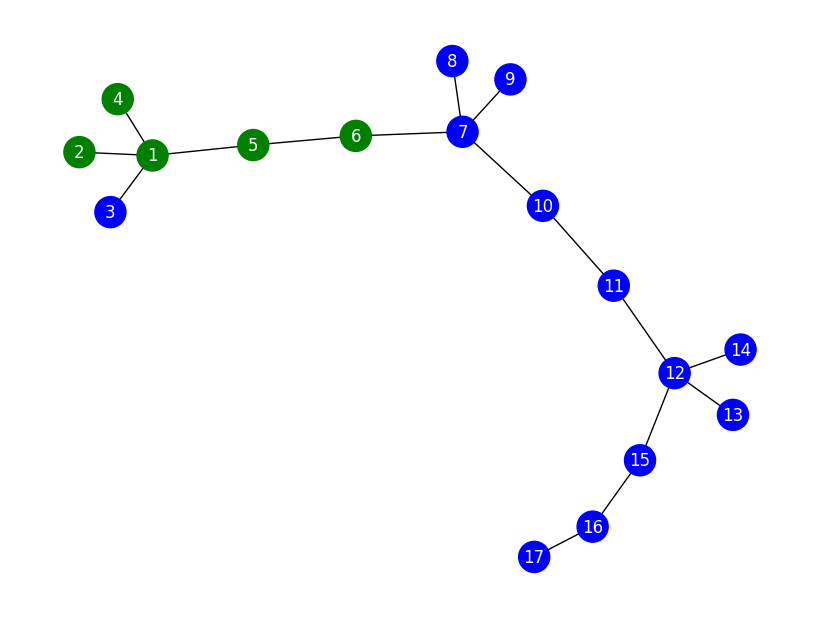

In [ ]:
import networkx as nx
from networkx.algorithms import isomorphism
import matplotlib.pyplot as plt

# Convert node labels of G and start_mer_no_sidechain to integers
G = nx.relabel_nodes(G, lambda x: int(x))
start_mer_no_sidechain = nx.relabel_nodes(start_mer_no_sidechain, lambda x: int(x))

# Perform subgraph isomorphism
GM = isomorphism.GraphMatcher(G, start_mer_no_sidechain)

# Check if the small graph is a subgraph of the big graph
if GM.subgraph_is_isomorphic():
    print("The small graph is a subgraph of the big graph")
    mapping = GM.mapping
    print("Mapping of nodes:", mapping)

    # Create a set of nodes in the subgraph based on the mapping
    subgraph_nodes = set(mapping.values())

    # Print the vertices of G that have been mapped
    print("Vertices of G that have been mapped:", subgraph_nodes)

    # Create a list of colors for the nodes
    node_colors = []
    for node in G.nodes():
        if node in subgraph_nodes:
            node_colors.append('green')
        else:
            node_colors.append('blue')

    # Draw the big graph and highlight the subgraph
    pos = nx.spring_layout(G)

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')
    plt.show()
else:
    print("The small graph is not a subgraph of the big graph")


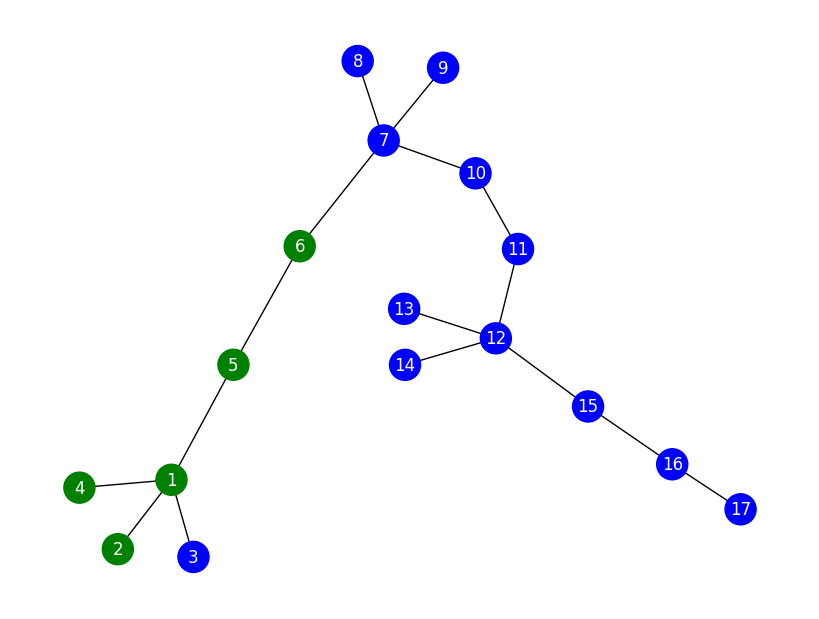

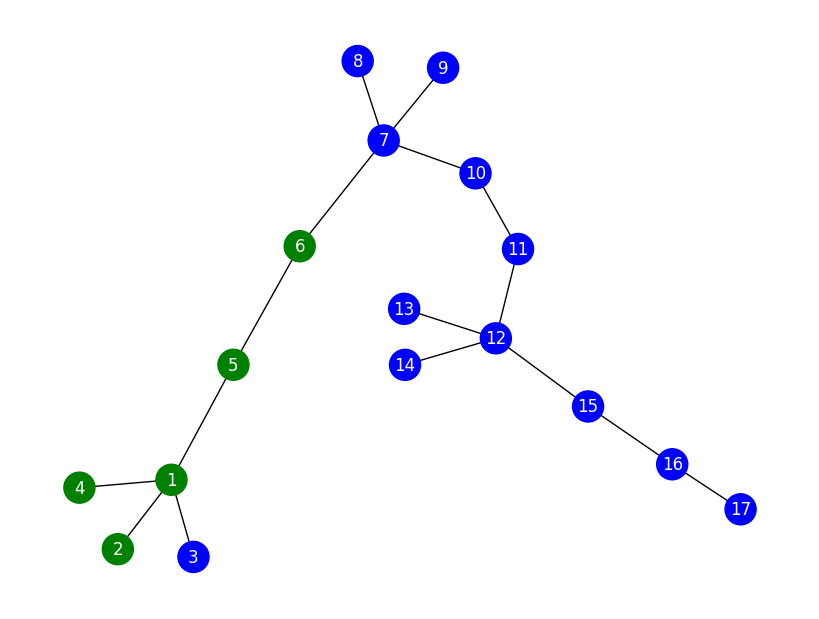

In [ ]:
import networkx as nx
from networkx.algorithms import isomorphism
import matplotlib.pyplot as plt

# Example graphs (replace with your actual graphs)
# G: Full graph
# start_mer_no_sidechain: Subgraph representing the start_mer_no_sidechain
# mid_mer_no_sidechain: Subgraph representing the mid_mer_no_sidechain

# Convert node labels of G and start_mer_no_sidechain to integers
G = nx.relabel_nodes(G, lambda x: int(x))
start_mer_no_sidechain = nx.relabel_nodes(start_mer_no_sidechain, lambda x: int(x))

# Perform subgraph isomorphism for start_mer_no_sidechain
GM = isomorphism.GraphMatcher(G, start_mer_no_sidechain)

if GM.subgraph_is_isomorphic():
    mapping = GM.mapping
    subgraph_nodes = set(mapping.values())

    # Create a list of colors for the nodes
    node_colors = []
    for node in G.nodes():
        if node in subgraph_nodes:
            node_colors.append('green')
        else:
            node_colors.append('blue')

    # Draw the big graph and highlight the subgraph
    pos = nx.spring_layout(G)

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')
    plt.show()

    # Extract subgraph containing only the blue vertices
    blue_nodes = [node for node in G.nodes() if node not in subgraph_nodes]
    G_blue_subgraph = G.subgraph(blue_nodes)

    # Convert node labels of G_blue_subgraph and mid_mer_no_sidechain to integers
    G_blue_subgraph = nx.relabel_nodes(G_blue_subgraph, lambda x: int(x))
    mid_mer_no_sidechain = nx.relabel_nodes(mid_mer_no_sidechain, lambda x: int(x))

    # Perform subgraph isomorphism for mid_mer_no_sidechain
    GM_mid = isomorphism.GraphMatcher(G_blue_subgraph, mid_mer_no_sidechain)

    if GM_mid.subgraph_is_isomorphic():
        mapping_mid = GM_mid.mapping
        mid_subgraph_nodes = set(mapping_mid.values())

        # Update the node colors to highlight the mid_mer_no_sidechain subgraph
        for node in G_blue_subgraph.nodes():
            if node in mid_subgraph_nodes:
                node_colors[node] = 'red'

        # Draw the updated big graph with highlighted mid_mer_no_sidechain subgraph
        plt.figure(figsize=(8, 6))
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')
        plt.show()
    else:
        print("The mid_mer_no_sidechain is not a subgraph of the remaining blue vertices in the big graph")
else:
    print("The start_mer_no_sidechain is not a subgraph of the big graph")


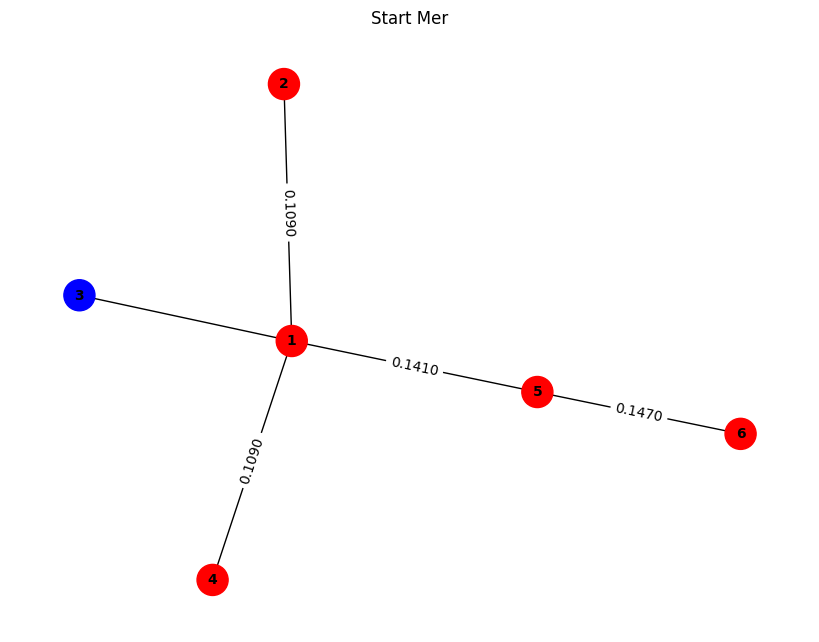

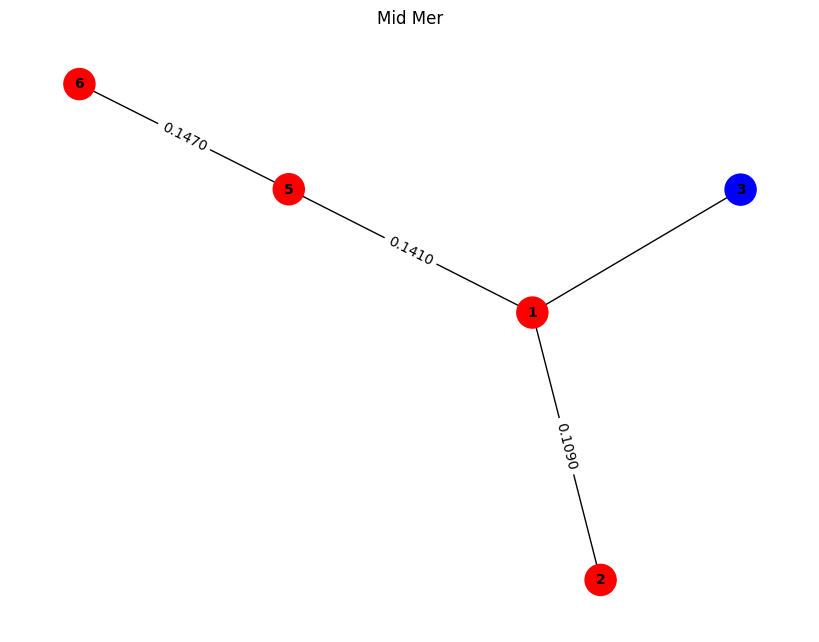

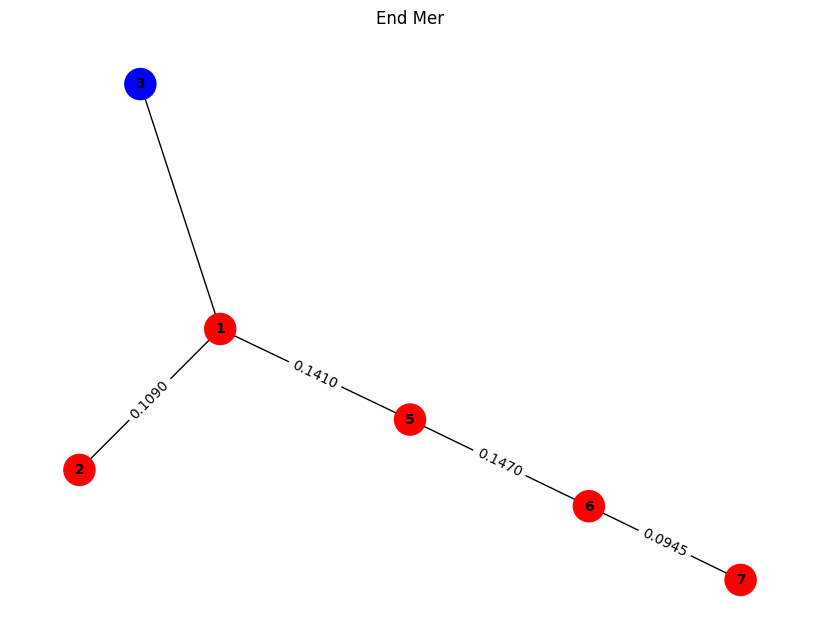

An error occurred: The node 4 is not in the graph.


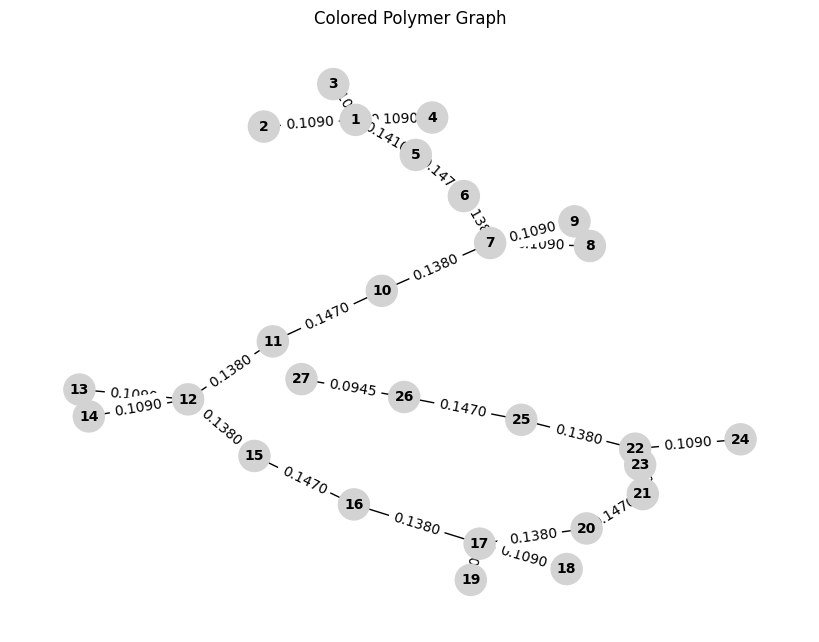

[2, 1, 3, 4, 5, 6]
[2, 1, 3, 5, 6]
[2, 1, 3, 5, 6, 7]


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to create a graph from the DataFrame
def bonds_to_graph(df_bonds):
    G = nx.Graph()
    for _, row in df_bonds.iterrows():
        G.add_edge(int(row['ai']), int(row['aj']), funct=row['funct'], b0=row['b0'], kb=row['kb'])
    return G

# Function to build the structure by removing specified hydrogen atoms
def build_structure(df_bonds, hydrogen_atoms, structure_type):
    start_hydrogen, end_hydrogen = hydrogen_atoms
    G = bonds_to_graph(df_bonds)

    if structure_type == 'start_mer':
        if G.has_node(end_hydrogen):
            G.remove_node(end_hydrogen)
    elif structure_type == 'mid_mer':
        if G.has_node(start_hydrogen):
            G.remove_node(start_hydrogen)
        if G.has_node(end_hydrogen):
            G.remove_node(end_hydrogen)
    elif structure_type == 'end_mer':
        if G.has_node(start_hydrogen):
            G.remove_node(start_hydrogen)

    return G

# Function to identify sidechain nodes in the mer graph
def identify_sidechain_nodes(mer_graph, sidechain_bond):
    backbone_node, sidechain_node = map(int, sidechain_bond)
    mer_graph.remove_edge(backbone_node, sidechain_node)
    sidechain_nodes = set(nx.node_connected_component(mer_graph, sidechain_node))
    mer_graph.add_edge(backbone_node, sidechain_node)
    return sidechain_nodes

# Function to fit the mer graph to the polymer graph
def fit_mer_to_polymer(mer_graph, polymer_graph, start_node, mer_start_node, ignore_sidechain):
    mer_nodes = set(mer_graph.nodes()) - set(ignore_sidechain)
    mapping = {mer_start_node: start_node}
    queue = [(start_node, mer_start_node)]
    visited_mer_nodes = set([mer_start_node])
    visited_polymer_nodes = set([start_node])

    while queue:
        polymer_node, mer_node = queue.pop(0)
        for neighbor in mer_graph.neighbors(mer_node):
            if neighbor not in visited_mer_nodes:
                for polymer_neighbor in polymer_graph.neighbors(polymer_node):
                    if polymer_neighbor not in visited_polymer_nodes:
                        queue.append((polymer_neighbor, neighbor))
                        visited_polymer_nodes.add(polymer_neighbor)
                        visited_mer_nodes.add(neighbor)
                        mapping[neighbor] = polymer_neighbor
                        break

    if len(mapping) != len(mer_nodes):
        raise ValueError("Could not map all nodes from mer to polymer.")

    return mapping

# Function to color the graph based on backbone and sidechain nodes
def color_graph(G, sidechain_bond):
    backbone_node, sidechain_node = map(int, sidechain_bond)

    if G.has_edge(backbone_node, sidechain_node):
        G.remove_edge(backbone_node, sidechain_node)

    backbone_nodes = set(nx.node_connected_component(G, backbone_node))
    sidechain_nodes = set(G.nodes()) - backbone_nodes
    G.add_edge(backbone_node, sidechain_node)

    color_map = []
    for node in G:
        if node in backbone_nodes:
            color_map.append('red')
        elif node in sidechain_nodes:
            color_map.append('blue')
        else:
            color_map.append('green')

    return color_map

# Function to draw the graph with colored nodes
def draw_colored_graph(G, color_map, title):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'b0')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Updated function to color the polymer graph
def color_polymer_graph(polymer_graph, start_mer, mid_mer, end_mer, sidechain_bond, n, polymer_start_hydrogen, start_hydrogen):
    color_map = ['lightgrey'] * len(polymer_graph.nodes())
    shades_of_grey = ['#D3D3D3', '#A9A9A9', '#808080', '#696969', '#505050']

    # Fit start_mer to the polymer
    start_sidechain_nodes = identify_sidechain_nodes(start_mer, sidechain_bond)
    start_mapping = fit_mer_to_polymer(start_mer, polymer_graph, polymer_start_hydrogen, start_hydrogen, ignore_sidechain=start_sidechain_nodes)
    for mer_node, polymer_node in start_mapping.items():
        color_map[polymer_node] = shades_of_grey[0]

    previous_mapping = start_mapping

    # Fit mid_mer to the polymer n-2 times
    for i in range(1, n - 1):
        end_hydrogen_node = list(previous_mapping.values())[-1]
        start_node = None
        for neighbor in polymer_graph.neighbors(end_hydrogen_node):
            if neighbor not in previous_mapping.values():
                start_node = neighbor
                break
        if start_node is None:
            raise ValueError("No valid starting node found for mid_mer fitting.")

        mid_sidechain_nodes = identify_sidechain_nodes(mid_mer, sidechain_bond)
        mid_mapping = fit_mer_to_polymer(mid_mer, polymer_graph, start_node, start_hydrogen, ignore_sidechain=mid_sidechain_nodes)
        for mer_node, polymer_node in mid_mapping.items():
            color_map[polymer_node] = shades_of_grey[i]

        previous_mapping = mid_mapping

    # Fit end_mer to the polymer
    end_hydrogen_node = list(previous_mapping.values())[-1]
    start_node = None
    for neighbor in polymer_graph.neighbors(end_hydrogen_node):
        if neighbor not in previous_mapping.values():
            start_node = neighbor
            break
    if start_node is None:
        raise ValueError("No valid starting node found for end_mer fitting.")

    end_sidechain_nodes = identify_sidechain_nodes(end_mer, sidechain_bond)
    end_mapping = fit_mer_to_polymer(end_mer, polymer_graph, start_node, start_hydrogen, ignore_sidechain=end_sidechain_nodes)
    for mer_node, polymer_node in end_mapping.items():
        color_map[polymer_node] = shades_of_grey[n-1]

    for node in polymer_graph.nodes():
        if node in start_mapping.values() or node in mid_mapping.values() or node in end_mapping.values():
            continue
        if node in identify_sidechain_nodes(polymer_graph, sidechain_bond):
            color_map[node] = 'blue'

    return color_map

# Example: Assume start_hydrogen is 4 and end_hydrogen is 7
start_hydrogen = 4
end_hydrogen = 7

# Example sidechain bond
sidechain_bond = ['1', '3']

# Build the structures
start_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'start_mer')
mid_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'mid_mer')
end_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'end_mer')

# Color the graphs
color_map_start = color_graph(start_mer, sidechain_bond)
color_map_mid = color_graph(mid_mer, sidechain_bond)
color_map_end = color_graph(end_mer, sidechain_bond)

# Draw the colored graphs
draw_colored_graph(start_mer, color_map_start, "Start Mer")
draw_colored_graph(mid_mer, color_map_mid, "Mid Mer")
draw_colored_graph(end_mer, color_map_end, "End Mer")

# Example polymer graph (5mer)
polymer_graph = bonds_to_graph(df3_bonds)

# Example: Number of mer units in the polymer and starting hydrogen node
n = 5
polymer_start_hydrogen = 4

# Define a default color map
color_map_polymer = ['lightgrey'] * len(polymer_graph.nodes())

try:
    # Color the polymer graph
    color_map_polymer = color_polymer_graph(polymer_graph, start_mer, mid_mer, end_mer, sidechain_bond, n, polymer_start_hydrogen, start_hydrogen)
except Exception as e:
    print(f"An error occurred: {e}")

# Draw the colored polymer graph
draw_colored_graph(polymer_graph, color_map_polymer, "Colored Polymer Graph")

print(start_mer.nodes)
print(mid_mer.nodes)
print(end_mer.nodes)

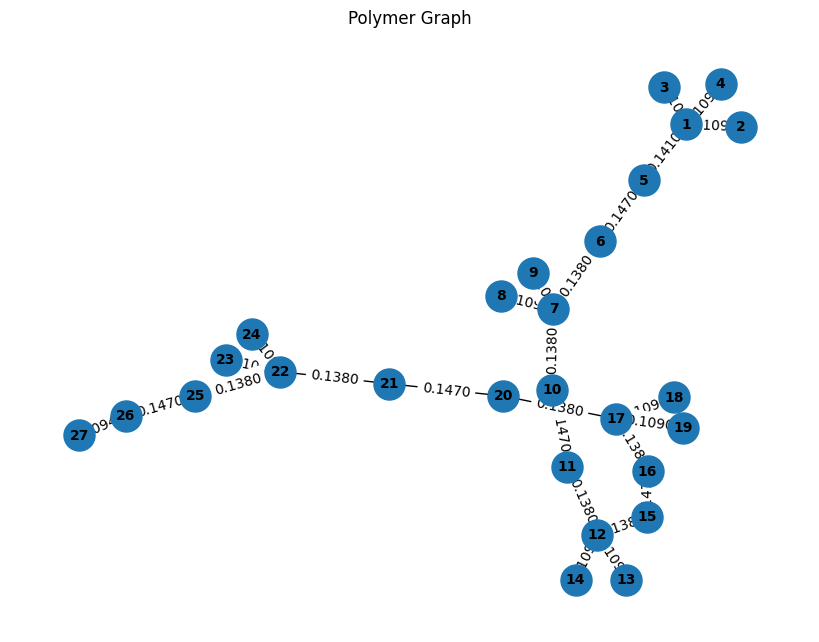

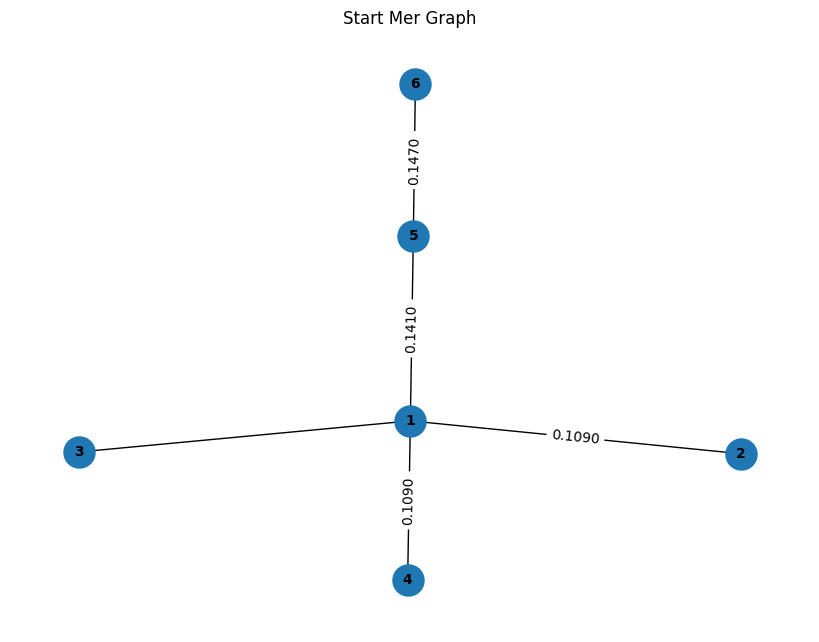

Start Mer Graph Nodes: [2, 1, 3, 4, 5, 6]
Start Mer Graph Edges: [(2, 1, {'funct': '1', 'b0': '0.1090', 'kb': '284512.000'}), (1, 4, {'funct': '1', 'b0': '0.1090', 'kb': '284512.000'}), (1, 5, {'funct': '1', 'b0': '0.1410', 'kb': '267776.000'}), (1, 3, {}), (5, 6, {'funct': '1', 'b0': '0.1470', 'kb': '209200.000'})]
Polymer Graph Nodes: [2, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Polymer Graph Edges: [(2, 1, {'funct': '1', 'b0': '0.1090', 'kb': '284512.000'}), (1, 3, {'funct': '1', 'b0': '0.1090', 'kb': '284512.000'}), (1, 4, {'funct': '1', 'b0': '0.1090', 'kb': '284512.000'}), (1, 5, {'funct': '1', 'b0': '0.1410', 'kb': '267776.000'}), (5, 6, {'funct': '1', 'b0': '0.1470', 'kb': '209200.000'}), (6, 7, {'funct': '1', 'b0': '0.1380', 'kb': '267776.000'}), (7, 8, {'funct': '1', 'b0': '0.1090', 'kb': '284512.000'}), (7, 9, {'funct': '1', 'b0': '0.1090', 'kb': '284512.000'}), (7, 10, {'funct': '1', 'b0': '0.1380', 'kb': '267776.000'})

NetworkXError: The node 4 is not in the graph.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def identify_sidechain_nodes(mer_graph, sidechain_bond):
    """
    Identify sidechain nodes in the mer graph.
    :param mer_graph: Graph of the mer (start_mer, mid_mer, end_mer).
    :param sidechain_bond: List containing the nodes of the sidechain bond.
    :return: Set of sidechain nodes.
    """
    backbone_node, sidechain_node = map(int, sidechain_bond)
    mer_graph.remove_edge(backbone_node, sidechain_node)

    # Perform a BFS from the sidechain_node to identify all sidechain nodes
    sidechain_nodes = set(nx.node_connected_component(mer_graph, sidechain_node))

    # Re-add the edge
    mer_graph.add_edge(backbone_node, sidechain_node)

    return sidechain_nodes

def fit_mer_to_polymer(mer_graph, polymer_graph, start_node, mer_start_node, ignore_sidechain):
    """
    Fit the mer graph to the polymer graph starting from the start_node.
    :param mer_graph: Graph of the mer (start_mer, mid_mer, end_mer).
    :param polymer_graph: Graph of the polymer.
    :param start_node: Starting node in the polymer graph.
    :param mer_start_node: Starting node in the mer graph.
    :param ignore_sidechain: List of nodes to ignore in the mer graph (sidechain nodes).
    :return: Mapping of mer nodes to polymer nodes.
    """
    mer_nodes = set(mer_graph.nodes()) - set(ignore_sidechain)
    mapping = {mer_start_node: start_node}
    queue = [(start_node, mer_start_node)]
    visited_mer_nodes = set([mer_start_node])
    visited_polymer_nodes = set([start_node])

    while queue:
        polymer_node, mer_node = queue.pop(0)
        print(f"Mapping polymer node {polymer_node} to mer node {mer_node}")
        for neighbor in mer_graph.neighbors(mer_node):
            if neighbor not in visited_mer_nodes:
                for polymer_neighbor in polymer_graph.neighbors(polymer_node):
                    if polymer_neighbor not in visited_polymer_nodes:
                        queue.append((polymer_neighbor, neighbor))
                        visited_polymer_nodes.add(polymer_neighbor)
                        visited_mer_nodes.add(neighbor)
                        mapping[neighbor] = polymer_neighbor
                        break

    if len(mapping) != len(mer_nodes):
        print(f"Failed to map all nodes from mer to polymer. Mapped nodes: {mapping}")
        print(f"Unmapped nodes in mer: {mer_nodes - set(mapping.keys())}")
        print(f"Unvisited nodes in polymer: {set(polymer_graph.nodes()) - visited_polymer_nodes}")
        raise ValueError("Could not map all nodes from mer to polymer.")

    return mapping

def color_polymer_graph(polymer_graph, start_mer, mid_mer, end_mer, sidechain_bond, n, polymer_start_hydrogen, start_hydrogen):
    """
    Color the polymer graph based on the start, mid, and end mer fits.
    :param polymer_graph: Graph of the polymer.
    :param start_mer: Graph of the start mer.
    :param mid_mer: Graph of the mid mer.
    :param end_mer: Graph of the end mer.
    :param sidechain_bond: List containing the nodes of the sidechain bond.
    :param n: Number of mer units in the polymer.
    :param polymer_start_hydrogen: Starting hydrogen node in the polymer graph.
    :param start_hydrogen: Starting hydrogen node in the mer graph.
    :return: Color mapping for the polymer graph nodes.
    """
    color_map = ['gray'] * len(polymer_graph.nodes())

    # Identify sidechain nodes
    start_sidechain_nodes = identify_sidechain_nodes(start_mer, sidechain_bond)
    mid_sidechain_nodes = identify_sidechain_nodes(mid_mer, sidechain_bond)
    end_sidechain_nodes = identify_sidechain_nodes(end_mer, sidechain_bond)

    # Fit start_mer to the polymer
    start_mapping = fit_mer_to_polymer(start_mer, polymer_graph, polymer_start_hydrogen, start_hydrogen, ignore_sidechain=start_sidechain_nodes)

    for mer_node, polymer_node in start_mapping.items():
        color_map[polymer_node] = 'red'

    # Fit mid_mer to the polymer
    previous_mapping = start_mapping
    for i in range(1, n - 1):
        # Find the node that shares an edge with the last node of the previous mapping
        end_hydrogen_node = list(previous_mapping.values())[-1]
        start_node = None
        for neighbor in polymer_graph.neighbors(end_hydrogen_node):
            if neighbor not in previous_mapping.values():
                start_node = neighbor
                break
        if start_node is None:
            # Relax constraints and allow the search to start from any unvisited node
            for candidate in polymer_graph.nodes():
                if candidate not in previous_mapping.values():
                    start_node = candidate
                    break

        if start_node is None:
            raise ValueError("No valid starting node found for mid_mer fitting.")

        mid_mapping = fit_mer_to_polymer(mid_mer, polymer_graph, start_node, start_hydrogen, ignore_sidechain=mid_sidechain_nodes)

        for mer_node, polymer_node in mid_mapping.items():
            color_map[polymer_node] = 'green'

        previous_mapping = mid_mapping

    # Fit end_mer to the polymer
    end_hydrogen_node = list(previous_mapping.values())[-1]
    start_node = None
    for neighbor in polymer_graph.neighbors(end_hydrogen_node):
        if neighbor not in previous_mapping.values():
            start_node = neighbor
            break
    if start_node is None:
        # Relax constraints and allow the search to start from any unvisited node
        for candidate in polymer_graph.nodes():
            if candidate not in previous_mapping.values():
                start_node = candidate
                break

    if start_node is None:
        raise ValueError("No valid starting node found for end_mer fitting.")

    end_mapping = fit_mer_to_polymer(end_mer, polymer_graph, start_node, start_hydrogen, ignore_sidechain=end_sidechain_nodes)

    for mer_node, polymer_node in end_mapping.items():
        color_map[polymer_node] = 'blue'

    return color_map

# Draw the polymer graph with colored nodes
def draw_colored_graph(G, color_map, title):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'b0')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Function to draw any given graph
def draw_graph(G, title):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500, font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'b0')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Example polymer graph (3mer)
polymer_graph = bonds_to_graph(df3_bonds)

# Draw the polymer graph
draw_graph(polymer_graph, "Polymer Graph")

# Example start mer graph
# Assuming start_mer, mid_mer, end_mer graphs are defined
draw_graph(start_mer, "Start Mer Graph")

# Example: Number of mer units in the polymer and starting hydrogen node
n = 5
polymer_start_hydrogen = 4

# Example sidechain bond
sidechain_bond = ['1', '3']

# Print the start_mer and polymer_graph structures
print("Start Mer Graph Nodes:", start_mer.nodes())
print("Start Mer Graph Edges:", start_mer.edges(data=True))

print("Polymer Graph Nodes:", polymer_graph.nodes())
print("Polymer Graph Edges:", polymer_graph.edges(data=True))

# Color the polymer graph
color_map = color_polymer_graph(polymer_graph, start_mer, mid_mer, end_mer, sidechain_bond, n, polymer_start_hydrogen, start_hydrogen)

# Draw the colored polymer graph
draw_colored_graph(polymer_graph, color_map, "Colored Polymer Graph")

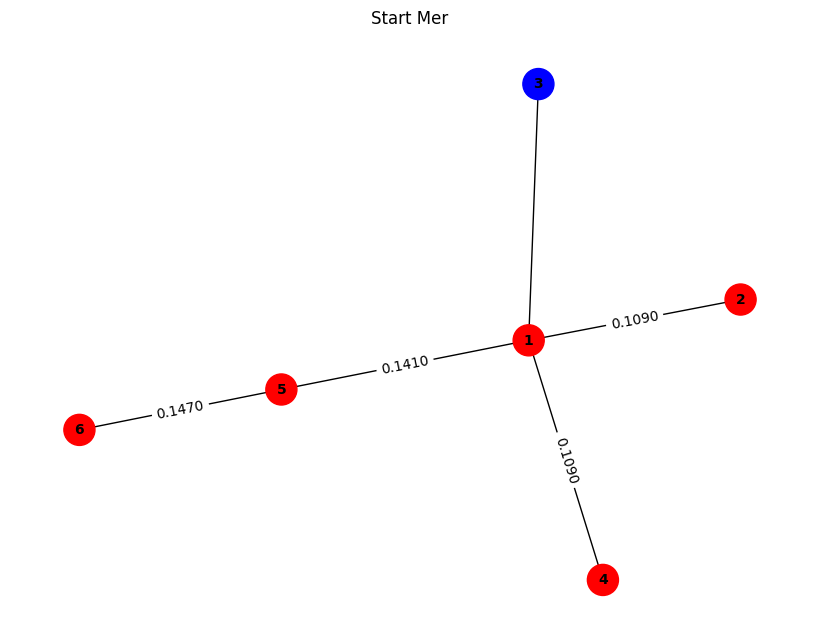

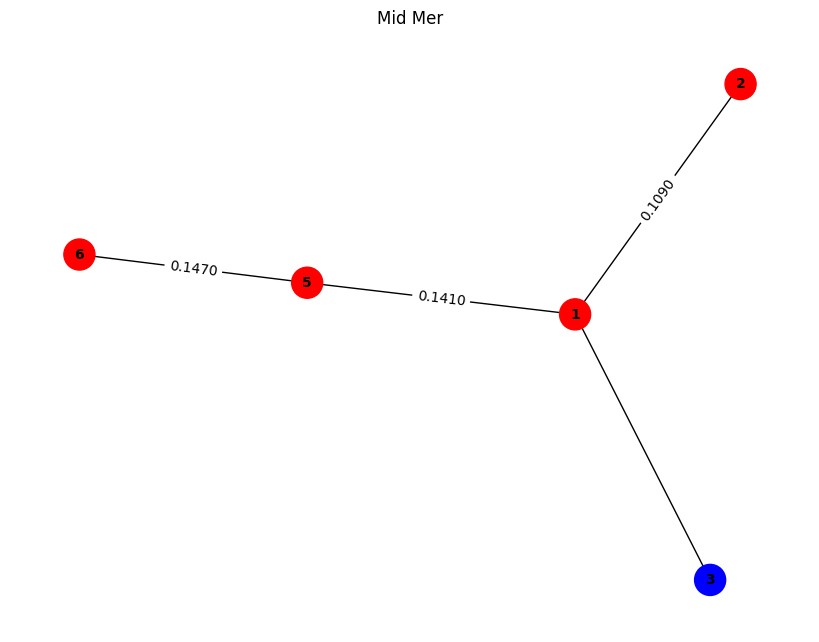

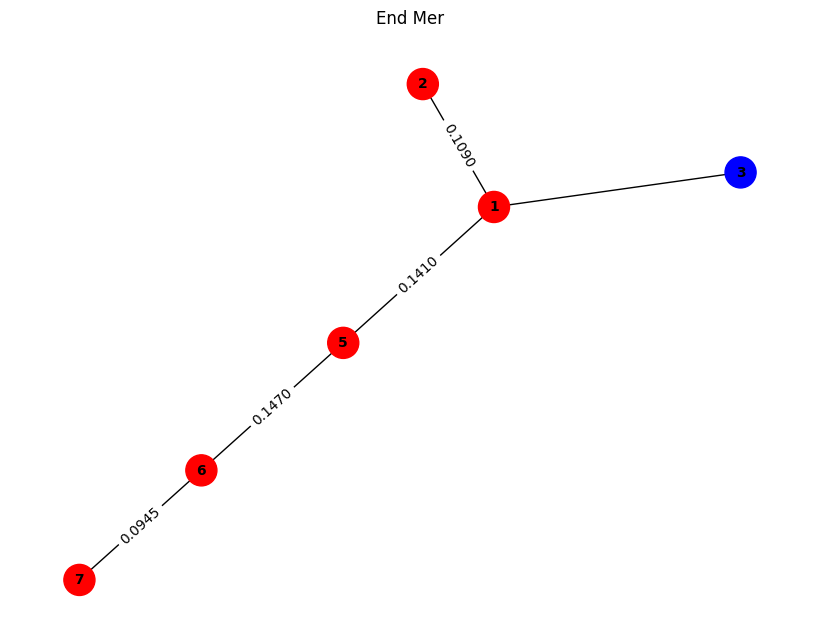

Start mer sidechain nodes: {3}
Start fitting: start_node=4, mer_start_node=4
Initial polymer graph nodes: [2, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Initial mer graph nodes: [2, 1, 3, 4, 5, 6]
Mapping polymer node 4 to mer node 4
Mapping polymer node 1 to mer node 1
Mapping polymer node 2 to mer node 2
Mapping polymer node 3 to mer node 5
Mapping polymer node 5 to mer node 3
Start mer mapping: {4: 4, 1: 1, 2: 2, 5: 3, 3: 5}
Mid mer sidechain nodes: {3}
Start fitting: start_node=6, mer_start_node=4
Initial polymer graph nodes: [2, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Initial mer graph nodes: [2, 1, 3, 5, 6]
Mapping polymer node 6 to mer node 4
An error occurred: The node 4 is not in the graph.


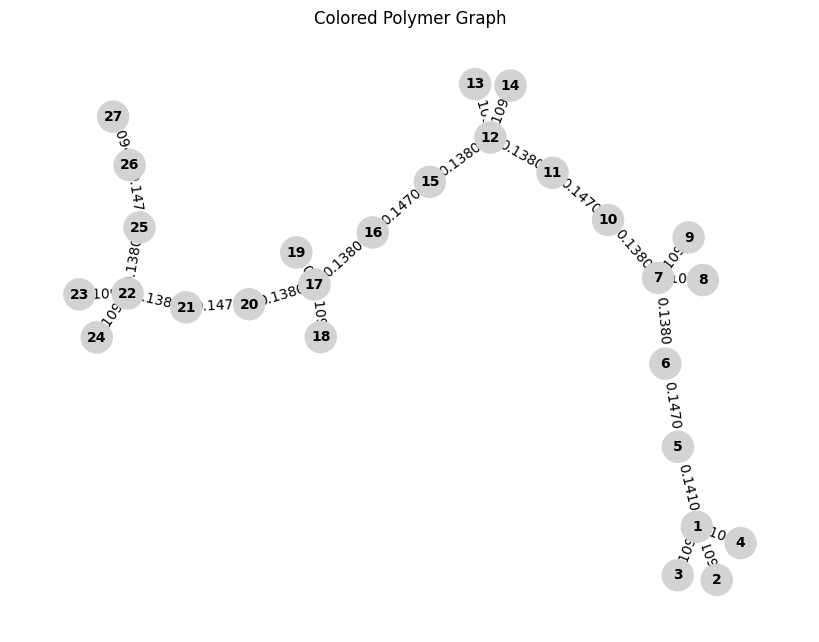

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Function to create a graph from the DataFrame
def bonds_to_graph(df_bonds):
    G = nx.Graph()
    for _, row in df_bonds.iterrows():
        G.add_edge(int(row['ai']), int(row['aj']), funct=row['funct'], b0=row['b0'], kb=row['kb'])
    return G

# Function to build the structure by removing specified hydrogen atoms
def build_structure(df_bonds, hydrogen_atoms, structure_type):
    start_hydrogen, end_hydrogen = hydrogen_atoms
    G = bonds_to_graph(df_bonds)

    if structure_type == 'start_mer':
        if G.has_node(end_hydrogen):
            G.remove_node(end_hydrogen)
    elif structure_type == 'mid_mer':
        if G.has_node(start_hydrogen):
            G.remove_node(start_hydrogen)
        if G.has_node(end_hydrogen):
            G.remove_node(end_hydrogen)
    elif structure_type == 'end_mer':
        if G.has_node(start_hydrogen):
            G.remove_node(start_hydrogen)

    return G

# Function to identify sidechain nodes in the mer graph
def identify_sidechain_nodes(mer_graph, sidechain_bond):
    backbone_node, sidechain_node = map(int, sidechain_bond)
    mer_graph.remove_edge(backbone_node, sidechain_node)
    sidechain_nodes = set(nx.node_connected_component(mer_graph, sidechain_node))
    mer_graph.add_edge(backbone_node, sidechain_node)
    return sidechain_nodes

# Function to fit the mer graph to the polymer graph
def fit_mer_to_polymer(mer_graph, polymer_graph, start_node, mer_start_node, ignore_sidechain):
    mer_nodes = set(mer_graph.nodes()) - set(ignore_sidechain)
    mapping = {mer_start_node: start_node}
    queue = [(start_node, mer_start_node)]
    visited_mer_nodes = set([mer_start_node])
    visited_polymer_nodes = set([start_node])

    print(f"Start fitting: start_node={start_node}, mer_start_node={mer_start_node}")
    print(f"Initial polymer graph nodes: {polymer_graph.nodes()}")
    print(f"Initial mer graph nodes: {mer_graph.nodes()}")

    while queue:
        polymer_node, mer_node = queue.pop(0)
        print(f"Mapping polymer node {polymer_node} to mer node {mer_node}")
        for neighbor in mer_graph.neighbors(mer_node):
            if neighbor not in visited_mer_nodes:
                for polymer_neighbor in polymer_graph.neighbors(polymer_node):
                    if polymer_neighbor not in visited_polymer_nodes:
                        queue.append((polymer_neighbor, neighbor))
                        visited_polymer_nodes.add(polymer_neighbor)
                        visited_mer_nodes.add(neighbor)
                        mapping[neighbor] = polymer_neighbor
                        break

    if len(mapping) != len(mer_nodes):
        print(f"Failed to map all nodes from mer to polymer. Mapped nodes: {mapping}")
        print(f"Unmapped nodes in mer: {mer_nodes - set(mapping.keys())}")
        print(f"Unvisited nodes in polymer: {set(polymer_graph.nodes()) - visited_polymer_nodes}")
        raise ValueError("Could not map all nodes from mer to polymer.")

    return mapping

# Function to color the graph based on backbone and sidechain nodes
def color_graph(G, sidechain_bond):
    backbone_node, sidechain_node = map(int, sidechain_bond)

    if G.has_edge(backbone_node, sidechain_node):
        G.remove_edge(backbone_node, sidechain_node)

    backbone_nodes = set(nx.node_connected_component(G, backbone_node))
    sidechain_nodes = set(G.nodes()) - backbone_nodes
    G.add_edge(backbone_node, sidechain_node)

    color_map = []
    for node in G:
        if node in backbone_nodes:
            color_map.append('red')
        elif node in sidechain_nodes:
            color_map.append('blue')
        else:
            color_map.append('green')

    return color_map

# Function to draw the graph with colored nodes
def draw_colored_graph(G, color_map, title):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'b0')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Updated function to color the polymer graph
def color_polymer_graph(polymer_graph, start_mer, mid_mer, end_mer, sidechain_bond, n, polymer_start_hydrogen, start_hydrogen):
    color_map = ['lightgrey'] * len(polymer_graph.nodes())
    shades_of_grey = ['#D3D3D3', '#A9A9A9', '#808080', '#696969', '#505050']

    # Fit start_mer to the polymer
    start_sidechain_nodes = identify_sidechain_nodes(start_mer, sidechain_bond)
    print(f"Start mer sidechain nodes: {start_sidechain_nodes}")
    start_mapping = fit_mer_to_polymer(start_mer, polymer_graph, polymer_start_hydrogen, start_hydrogen, ignore_sidechain=start_sidechain_nodes)
    print(f"Start mer mapping: {start_mapping}")
    for mer_node, polymer_node in start_mapping.items():
        color_map[polymer_node] = shades_of_grey[0]

    previous_mapping = start_mapping

    # Fit mid_mer to the polymer n-2 times
    for i in range(1, n - 1):
        end_hydrogen_node = list(previous_mapping.values())[-1]
        start_node = None
        for neighbor in polymer_graph.neighbors(end_hydrogen_node):
            if neighbor not in previous_mapping.values():
                start_node = neighbor
                break
        if start_node is None:
            raise ValueError("No valid starting node found for mid_mer fitting.")

        mid_sidechain_nodes = identify_sidechain_nodes(mid_mer, sidechain_bond)
        print(f"Mid mer sidechain nodes: {mid_sidechain_nodes}")
        mid_mapping = fit_mer_to_polymer(mid_mer, polymer_graph, start_node, start_hydrogen, ignore_sidechain=mid_sidechain_nodes)
        print(f"Mid mer mapping: {mid_mapping}")
        for mer_node, polymer_node in mid_mapping.items():
            color_map[polymer_node] = shades_of_grey[i]

        previous_mapping = mid_mapping

    # Fit end_mer to the polymer
    end_hydrogen_node = list(previous_mapping.values())[-1]
    start_node = None
    for neighbor in polymer_graph.neighbors(end_hydrogen_node):
        if neighbor not in previous_mapping.values():
            start_node = neighbor
            break
    if start_node is None:
        raise ValueError("No valid starting node found for end_mer fitting.")

    end_sidechain_nodes = identify_sidechain_nodes(end_mer, sidechain_bond)
    print(f"End mer sidechain nodes: {end_sidechain_nodes}")
    end_mapping = fit_mer_to_polymer(end_mer, polymer_graph, start_node, start_hydrogen, ignore_sidechain=end_sidechain_nodes)
    print(f"End mer mapping: {end_mapping}")
    for mer_node, polymer_node in end_mapping.items():
        color_map[polymer_node] = shades_of_grey[n-1]

    for node in polymer_graph.nodes():
        if node in start_mapping.values() or node in mid_mapping.values() or node in end_mapping.values():
            continue
        if node in identify_sidechain_nodes(polymer_graph, sidechain_bond):
            color_map[node] = 'blue'

    return color_map

# Build the structures
start_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'start_mer')
mid_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'mid_mer')
end_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'end_mer')

# Color the graphs
color_map_start = color_graph(start_mer, sidechain_bond)
color_map_mid = color_graph(mid_mer, sidechain_bond)
color_map_end = color_graph(end_mer, sidechain_bond)

# Draw the colored graphs
draw_colored_graph(start_mer, color_map_start, "Start Mer")
draw_colored_graph(mid_mer, color_map_mid, "Mid Mer")
draw_colored_graph(end_mer, color_map_end, "End Mer")

# Example polymer graph (5mer)
polymer_graph = bonds_to_graph(df3_bonds)

# Example: Number of mer units in the polymer and starting hydrogen node
n = 5
polymer_start_hydrogen = 4

# Define a default color map
color_map_polymer = ['lightgrey'] * len(polymer_graph.nodes())

try:
    # Color the polymer graph
    color_map_polymer = color_polymer_graph(polymer_graph, start_mer, mid_mer, end_mer, sidechain_bond, n, polymer_start_hydrogen, start_hydrogen)
except Exception as e:
    print(f"An error occurred: {e}")

# Draw the colored polymer graph
draw_colored_graph(polymer_graph, color_map_polymer, "Colored Polymer Graph")


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to create a graph from the DataFrame
def bonds_to_graph(df_bonds):
    G = nx.Graph()
    for _, row in df_bonds.iterrows():
        G.add_edge(int(row['ai']), int(row['aj']), funct=row['funct'], b0=row['b0'], kb=row['kb'])
    return G

# Function to build the structure by removing specified hydrogen atoms
def build_structure(df_bonds, hydrogen_atoms, structure_type):
    start_hydrogen, end_hydrogen = hydrogen_atoms
    G = bonds_to_graph(df_bonds)

    if structure_type == 'start_mer':
        if G.has_node(end_hydrogen):
            G.remove_node(end_hydrogen)
    elif structure_type == 'mid_mer':
        if G.has_node(start_hydrogen):
            G.remove_node(start_hydrogen)
        if G.has_node(end_hydrogen):
            G.remove_node(end_hydrogen)
    elif structure_type == 'end_mer':
        if G.has_node(start_hydrogen):
            G.remove_node(start_hydrogen)

    return G

# Function to identify sidechain nodes in the mer graph
def identify_sidechain_nodes(mer_graph, sidechain_bond):
    backbone_node, sidechain_node = map(int, sidechain_bond)
    mer_graph.remove_edge(backbone_node, sidechain_node)
    sidechain_nodes = set(nx.node_connected_component(mer_graph, sidechain_node))
    mer_graph.add_edge(backbone_node, sidechain_node)
    return sidechain_nodes

# Function to fit the mer graph to the polymer graph
def fit_mer_to_polymer(mer_graph, polymer_graph, start_node, mer_start_node, ignore_sidechain):
    mer_nodes = set(mer_graph.nodes()) - set(ignore_sidechain)
    mapping = {mer_start_node: start_node}
    queue = [(start_node, mer_start_node)]
    visited_mer_nodes = set([mer_start_node])
    visited_polymer_nodes = set([start_node])

    while queue:
        polymer_node, mer_node = queue.pop(0)
        for neighbor in mer_graph.neighbors(mer_node):
            if neighbor not in visited_mer_nodes:
                for polymer_neighbor in polymer_graph.neighbors(polymer_node):
                    if polymer_neighbor not in visited_polymer_nodes:
                        queue.append((polymer_neighbor, neighbor))
                        visited_polymer_nodes.add(polymer_neighbor)
                        visited_mer_nodes.add(neighbor)
                        mapping[neighbor] = polymer_neighbor
                        break

    if len(mapping) != len(mer_nodes):
        print(f"Failed to map all nodes from mer to polymer. Mapped nodes: {mapping}")
        print(f"Unmapped nodes in mer: {mer_nodes - set(mapping.keys())}")
        print(f"Unvisited nodes in polymer: {set(polymer_graph.nodes()) - visited_polymer_nodes}")
        raise ValueError("Could not map all nodes from mer to polymer.")

    return mapping

# Function to color the graph based on backbone and sidechain nodes
def color_graph(G, sidechain_bond, start_mapping, mid_mappings, end_mapping):
    backbone_node, sidechain_node = map(int, sidechain_bond)
    color_map = ['grey'] * len(G.nodes())

    for idx, (mer_node, polymer_node) in enumerate(start_mapping.items()):
        color_map[polymer_node] = 'red'

    shades_of_grey = ['#D3D3D3', '#A9A9A9', '#808080', '#696969', '#505050']
    for i, mid_mapping in enumerate(mid_mappings):
        for idx, (mer_node, polymer_node) in enumerate(mid_mapping.items()):
            color_map[polymer_node] = shades_of_grey[i % len(shades_of_grey)]

    for idx, (mer_node, polymer_node) in enumerate(end_mapping.items()):
        color_map[polymer_node] = 'blue'

    return color_map

# Function to draw the graph with colored nodes
def draw_colored_graph(G, color_map, title):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'b0')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Main function to process and visualize the polymer with grafted sidechains
def process_polymer_with_sidechains(df1_bonds, df3_bonds, sidechain_bond, start_hydrogen, end_hydrogen, n):
    # Build the structures
    start_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'start_mer')
    mid_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'mid_mer')
    end_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'end_mer')

    # Example polymer graph (n-mer)
    polymer_graph = bonds_to_graph(df3_bonds)

    # Fit start_mer to the polymer
    start_sidechain_nodes = identify_sidechain_nodes(start_mer, sidechain_bond)
    start_mapping = fit_mer_to_polymer(start_mer, polymer_graph, start_hydrogen, start_hydrogen, ignore_sidechain=start_sidechain_nodes)

    previous_mapping = start_mapping
    mid_mappings = []

    # Fit mid_mer to the polymer n-2 times
    for i in range(1, n - 1):
        end_hydrogen_node = list(previous_mapping.values())[-1]
        start_node = None
        for neighbor in polymer_graph.neighbors(end_hydrogen_node):
            if neighbor not in previous_mapping.values():
                start_node = neighbor
                break
        if start_node is None:
            raise ValueError("No valid starting node found for mid_mer fitting.")

        mid_sidechain_nodes = identify_sidechain_nodes(mid_mer, sidechain_bond)
        mid_mapping = fit_mer_to_polymer(mid_mer, polymer_graph, start_node, start_hydrogen, ignore_sidechain=mid_sidechain_nodes)
        mid_mappings.append(mid_mapping)
        previous_mapping = mid_mapping

    # Fit end_mer to the polymervalues())[-1]
    start_node = None
    for neighbor in polymer_graph.neighbors(end_hydrogen_node):
        if neighbor not in previous_mapping.values():
            start_node = neighbor
            break
    if start_node is None:
        raise ValueError("No valid starting node found for end_mer fitting.")

    end_sidechain_nodes = identify_sidechain_nodes(end_mer, sidechain_bond)
    end_mapping = fit_mer_to_polymer(end_mer, polymer_graph, start_node, start_hydrogen, ignore_sidechain=end_sidechain_nodes)

    # Color the polymer graph
    color_map_polymer = color_graph(polymer_graph, sidechain_bond, start_mapping, mid_mappings, end_mapping)

    # Draw the colored polymer graph
    draw_colored_graph(polymer_graph, color_map_polymer, "Final Polymer Graph with Grafted Sidechains")

# Parameters and example data (replace with actual data)
sidechain_bond = ['1', '3']
start_hydrogen = 4
end_hydrogen = 7
n = 5

# Process and visualize the polymer with grafted sidechains
process_polymer_with_sidechains(df1_bonds, df3_bonds, sidechain_bond, start_hydrogen, end_hydrogen, n)

    end_hydrogen_node = list(previous_mapping.

NetworkXError: The node 4 is not in the graph.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to create a graph from the DataFrame
def bonds_to_graph(df_bonds):
    G = nx.Graph()
    for _, row in df_bonds.iterrows():
        G.add_edge(int(row['ai']), int(row['aj']), funct=row['funct'], b0=row['b0'], kb=row['kb'])
    return G

# Function to build the structure by removing specified hydrogen atoms
def build_structure(df_bonds, hydrogen_atoms, structure_type):
    start_hydrogen, end_hydrogen = hydrogen_atoms
    G = bonds_to_graph(df_bonds)

    if structure_type == 'start_mer':
        if G.has_node(end_hydrogen):
            G.remove_node(end_hydrogen)
    elif structure_type == 'mid_mer':
        if G.has_node(start_hydrogen):
            G.remove_node(start_hydrogen)
        if G.has_node(end_hydrogen):
            G.remove_node(end_hydrogen)
    elif structure_type == 'end_mer':
        if G.has_node(start_hydrogen):
            G.remove_node(start_hydrogen)

    return G

# Function to identify sidechain nodes in the mer graph
def identify_sidechain_nodes(mer_graph, sidechain_bond):
    backbone_node, sidechain_node = map(int, sidechain_bond)
    mer_graph.remove_edge(backbone_node, sidechain_node)
    sidechain_nodes = set(nx.node_connected_component(mer_graph, sidechain_node))
    mer_graph.add_edge(backbone_node, sidechain_node)
    return sidechain_nodes

# Function to fit the mer graph to the polymer graph with retry logic
def fit_mer_to_polymer(mer_graph, polymer_graph, start_node, mer_start_node, ignore_sidechain, max_retries=5):
    for attempt in range(max_retries):
        try:
            return attempt_fit(mer_graph, polymer_graph, start_node, mer_start_node, ignore_sidechain)
        except ValueError as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            # Change the starting point if the attempt fails
            start_node = (start_node + 1) % len(polymer_graph.nodes())

    raise ValueError("All attempts to map mer to polymer failed.")

# Function to attempt fitting the mer graph to the polymer graph
def attempt_fit(mer_graph, polymer_graph, start_node, mer_start_node, ignore_sidechain):
    mer_nodes = set(mer_graph.nodes()) - set(ignore_sidechain)
    mapping = {mer_start_node: start_node}
    queue = [(start_node, mer_start_node)]
    visited_mer_nodes = set([mer_start_node])
    visited_polymer_nodes = set([start_node])

    while queue:
        polymer_node, mer_node = queue.pop(0)
        for neighbor in mer_graph.neighbors(mer_node):
            if neighbor not in visited_mer_nodes:
                for polymer_neighbor in polymer_graph.neighbors(polymer_node):
                    if polymer_neighbor not in visited_polymer_nodes:
                        queue.append((polymer_neighbor, neighbor))
                        visited_polymer_nodes.add(polymer_neighbor)
                        visited_mer_nodes.add(neighbor)
                        mapping[neighbor] = polymer_neighbor
                        break

    if len(mapping) != len(mer_nodes):
        print(f"Failed to map all nodes from mer to polymer. Mapped nodes: {mapping}")
        print(f"Unmapped nodes in mer: {mer_nodes - set(mapping.keys())}")
        print(f"Unvisited nodes in polymer: {set(polymer_graph.nodes()) - visited_polymer_nodes}")
        raise ValueError("Could not map all nodes from mer to polymer.")

    return mapping

# Function to color the graph based on backbone and sidechain nodes
def color_graph(G, sidechain_bond, start_mapping, mid_mappings, end_mapping):
    backbone_node, sidechain_node = map(int, sidechain_bond)
    color_map = ['grey'] * len(G.nodes())

    for idx, (mer_node, polymer_node) in enumerate(start_mapping.items()):
        color_map[polymer_node] = 'red'

    shades_of_grey = ['#D3D3D3', '#A9A9A9', '#808080', '#696969', '#505050']
    for i, mid_mapping in enumerate(mid_mappings):
        for idx, (mer_node, polymer_node) in enumerate(mid_mapping.items()):
            color_map[polymer_node] = shades_of_grey[i % len(shades_of_grey)]

    for idx, (mer_node, polymer_node) in enumerate(end_mapping.items()):
        color_map[polymer_node] = 'blue'

    return color_map

# Function to draw the graph with colored nodes
def draw_colored_graph(G, color_map, title):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'b0')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Main function to process and visualize the polymer with grafted sidechains
def process_polymer_with_sidechains(df1_bonds, df3_bonds, sidechain_bond, start_hydrogen, end_hydrogen, n):
    # Build the structures
    start_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'start_mer')
    mid_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'mid_mer')
    end_mer = build_structure(df1_bonds, (start_hydrogen, end_hydrogen), 'end_mer')

    # Example polymer graph (n-mer)
    polymer_graph = bonds_to_graph(df3_bonds)

    # Fit start_mer to the polymer
    start_sidechain_nodes = identify_sidechain_nodes(start_mer, sidechain_bond)
    print(f"Start mer sidechain nodes: {start_sidechain_nodes}")
    start_mapping = fit_mer_to_polymer(start_mer, polymer_graph, start_hydrogen, start_hydrogen, ignore_sidechain=start_sidechain_nodes)
    print(f"Start mer mapping: {start_mapping}")

    previous_mapping = start_mapping
    mid_mappings = []

    # Fit mid_mer to the polymer n-2 times
    for i in range(1, n - 1):
        end_hydrogen_node = list(previous_mapping.values())[-1]
        start_node = None
        for neighbor in polymer_graph.neighbors(end_hydrogen_node):
            if neighbor not in previous_mapping.values():
                start_node = neighbor
                break
        if start_node is None:
            raise ValueError("No valid starting node found for mid_mer fitting.")

        mid_sidechain_nodes = identify_sidechain_nodes(mid_mer, sidechain_bond)
        print(f"Mid mer sidechain nodes: {mid_sidechain_nodes}")
        mid_mapping = fit_mer_to_polymer(mid_mer, polymer_graph, start_node, start_hydrogen, ignore_sidechain=mid_sidechain_nodes)
        print(f"Mid mer mapping: {mid_mapping}")
        mid_mappings.append(mid_mapping)
        previous_mapping = mid_mapping

    # Fit end_mer to the polymer
    end_hydrogen_node = list(previous_mapping.values())[-1]
    start_node = None
    for neighbor in polymer_graph.neighbors(end_hydrogen_node):
        if neighbor not in previous_mapping.values():
            start_node = neighbor
            break
    if start_node is None:
        raise ValueError("No valid starting node found for end_mer fitting.")

    end_sidechain_nodes = identify_sidechain_nodes(end_mer, sidechain_bond)
    print(f"End mer sidechain nodes: {end_sidechain_nodes}")
    end_mapping = fit_mer_to_polymer(end_mer, polymer_graph, start_node, start_hydrogen, ignore_sidechain=end_sidechain_nodes)
    print(f"End mer mapping: {end_mapping}")

    # Color the polymer graph
    color_map_polymer = color_graph(polymer_graph, sidechain_bond, start_mapping, mid_mappings, end_mapping)

    # Draw the colored polymer graph
    draw_colored_graph(polymer_graph, color_map_polymer, "Final Polymer Graph with Grafted Sidechains")

# Parameters and example data (replace with actual data)
sidechain_bond = ['1', '3']
start_hydrogen = 4
end_hydrogen = 7
n = 5

# Process and visualize the polymer with grafted sidechains
process_polymer_with_sidechains(df1_bonds, df3_bonds, sidechain_bond, start_hydrogen, end_hydrogen, n)


Start mer sidechain nodes: {3}
Start mer mapping: {4: 4, 1: 1, 2: 2, 5: 3, 3: 5}
Mid mer sidechain nodes: {3}


NetworkXError: The node 4 is not in the graph.

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 33.9 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdchem
import networkx as nx

def parse_molecule(smiles):
    return Chem.MolFromSmiles(smiles)

def molecule_to_nx(mol):
    """Convert an RDKit molecule to a NetworkX graph."""
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), element=atom.GetSymbol())

    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), order=bond.GetBondTypeAsDouble())

    return G

def find_cycles(G):
    """Find all cycles in the graph G."""
    return list(nx.cycle_basis(G))

def identify_repeating_units(polymer_smiles):
    """Identify repeating units in the polymer."""
    polymer = Chem.MolFromSmiles(polymer_smiles)
    G = molecule_to_nx(polymer)

    # Find cycles in the graph (potential repeating units)
    cycles = find_cycles(G)

    repeating_units = []

    for cycle in cycles:
        subgraph = G.subgraph(cycle)
        repeating_unit = list(subgraph.nodes)
        repeating_units.append(repeating_unit)

    return repeating_units

def identify_sidechain(monomer_smiles):
    """Identify the sidechain in the monomer."""
    monomer = Chem.MolFromSmiles(monomer_smiles)

    # Get the number of atoms in the monomer
    num_atoms = monomer.GetNumAtoms()

    # Initialize an empty list to keep track of sidechains
    sidechains = []

    # Identify branching points (atoms with more than two bonds)
    branching_points = []
    for atom in monomer.GetAtoms():
        if atom.GetDegree() > 2:
            branching_points.append(atom.GetIdx())

    # Identify sidechains by exploring branches from branching points
    for bp in branching_points:
        visited = set()
        sidechain = []

        def dfs(atom_idx, depth):
            if atom_idx in visited or depth > 1:
                return
            visited.add(atom_idx)
            sidechain.append(atom_idx)
            atom = monomer.GetAtomWithIdx(atom_idx)
            for neighbor in atom.GetNeighbors():
                dfs(neighbor.GetIdx(), depth + 1)

        for neighbor in monomer.GetAtomWithIdx(bp).GetNeighbors():
            dfs(neighbor.GetIdx(), 0)

        sidechains.append(sidechain)

    # Identify the longest sidechain as the main sidechain
    main_sidechain = max(sidechains, key=len) if sidechains else None

    return main_sidechain

def graft_sidechain(polymer_smiles, sidechain_atom_indices, grafting_sites):
    """Graft a sidechain onto the polymer at specified grafting sites."""
    polymer = Chem.MolFromSmiles(polymer_smiles)

    # Convert the polymer molecule to editable form
    editable_polymer = Chem.RWMol(polymer)

    # Create a dictionary to store the mapping of original to new atom indices for the sidechain
    atom_idx_mapping = {}

    # Iterate through the grafting sites and add the sidechain atoms to the polymer
    for (graft_idx_polymer, graft_idx_sidechain) in grafting_sites:
        # Add the sidechain atoms to the polymer and keep track of the new indices
        for atom_idx in sidechain_atom_indices:
            atom = polymer.GetAtomWithIdx(atom_idx)
            new_atom_idx = editable_polymer.AddAtom(atom)
            atom_idx_mapping[atom_idx] = new_atom_idx

        # Add the bond between the grafting site in the polymer and the corresponding sidechain atom
        editable_polymer.AddBond(graft_idx_polymer, atom_idx_mapping[graft_idx_sidechain], rdchem.BondType.SINGLE)

        # Add the remaining bonds within the sidechain
        for i in range(len(sidechain_atom_indices) - 1):
            editable_polymer.AddBond(atom_idx_mapping[sidechain_atom_indices[i]], atom_idx_mapping[sidechain_atom_indices[i + 1]], rdchem.BondType.SINGLE)

    # Sanitize the modified polymer to correct any valence issues
    Chem.SanitizeMol(editable_polymer)

    return editable_polymer

def main(polymer_smiles, monomer_smiles):
    polymer = parse_molecule(polymer_smiles)
    monomer = parse_molecule(monomer_smiles)

    repeating_units = identify_repeating_units(polymer_smiles)
    sidechain = identify_sidechain(monomer_smiles)

    # Define grafting sites based on some logic or user input
    grafting_sites = [(2, sidechain[0])]  # Example: [(polymer_atom_index, sidechain_atom_index)]

    modified_polymer = graft_sidechain(polymer_smiles, sidechain, grafting_sites)

    return Chem.MolToSmiles(modified_polymer)

# Example usage
polymer_smiles = "OCOOCOOCO"  # Replace with actual SMILES
monomer_smiles = "CCCC(O)O"  # Replace with actual SMILES
modified_polymer_smiles = main(polymer_smiles, monomer_smiles)
print(modified_polymer_smiles)

[07:18:22] Explicit valence for atom # 2 O, 3, is greater than permitted


AtomValenceException: Explicit valence for atom # 2 O, 3, is greater than permitted

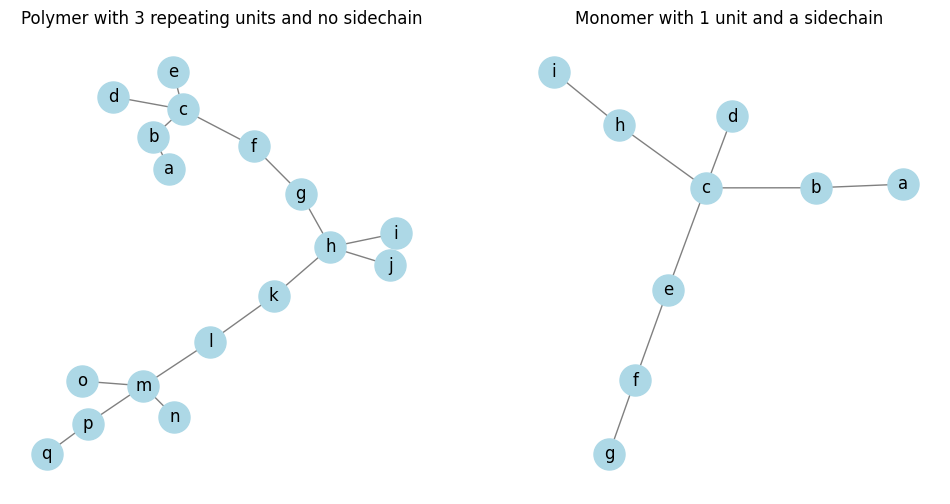

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the polymer with 3 repeating units and no special sidechain
G_polymer = nx.Graph()
edges_polymer = [('a', 'b'), ('b', 'c'), ('c', 'd'), ('c', 'e'), ('c', 'f'),
                 ('f', 'g'), ('g', 'h'), ('h', 'i'), ('h', 'j'), ('h', 'k'),
                 ('k', 'l'), ('l', 'm'), ('m', 'n'), ('m', 'o'), ('m', 'p'), ('p', 'q')]
G_polymer.add_edges_from(edges_polymer)

# Define the monomer with 1 unit and a special sidechain (e, f, g)
G_monomer = nx.Graph()
edges_monomer = [('a', 'b'), ('b', 'c'), ('c', 'd'), ('c', 'e'), ('e', 'f'), ('f', 'g'), ('c', 'h'), ('h', 'i')]
G_monomer.add_edges_from(edges_monomer)

# Draw the graphs
pos_polymer = nx.spring_layout(G_polymer)
pos_monomer = nx.spring_layout(G_monomer)

plt.figure(figsize=(12, 6))

plt.subplot(121)
nx.draw(G_polymer, pos=pos_polymer, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('Polymer with 3 repeating units and no sidechain')

plt.subplot(122)
nx.draw(G_monomer, pos=pos_monomer, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('Monomer with 1 unit and a sidechain')

plt.show()


In [ ]:
from networkx.algorithms.isomorphism import GraphMatcher

def find_grafting_location(G_polymer, G_monomer):
    gm = GraphMatcher(G_polymer, G_monomer)
    if gm.subgraph_is_isomorphic():
        for subgraph in gm.subgraph_isomorphisms_iter():
            monomer_nodes = set(subgraph.keys())
            polymer_nodes = set(G_polymer.nodes())
            grafting_candidates = polymer_nodes - monomer_nodes
            if grafting_candidates:
                return grafting_candidates
    return None

# Find grafting location
grafting_location = find_grafting_location(G_polymer, G_monomer)

# Print the results
print("Grafting location:", grafting_location)


Grafting location: None


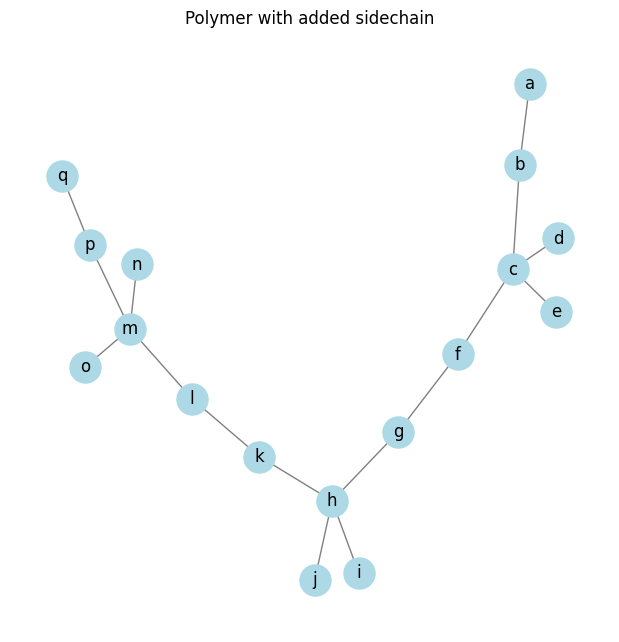

In [ ]:
# Add sidechain to the polymer at the grafting location
if grafting_location:
    grafting_node = list(grafting_location)[0]
    sidechain_edges = [(grafting_node, 'e'), ('e', 'f'), ('f', 'g')]
    G_polymer.add_edges_from(sidechain_edges)

# Draw the updated graph
pos_updated = nx.spring_layout(G_polymer)

plt.figure(figsize=(6, 6))
nx.draw(G_polymer, pos=pos_updated, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('Polymer with added sidechain')
plt.show()

In [ ]:
from networkx.algorithms.isomorphism import GraphMatcher

def split_polymer_into_units(G, unit_size):
    units = []
    nodes = list(G.nodes)
    for i in range(0, len(nodes), unit_size):
        subgraph_nodes = nodes[i:i + unit_size]
        subgraph = G.subgraph(subgraph_nodes).copy()
        units.append(subgraph)
    return units

def find_grafting_location(G_polymer, G_monomer, unit_size):
    units = split_polymer_into_units(G_polymer, unit_size)
    grafting_locations = []
    for unit in units:
        gm = GraphMatcher(unit, G_monomer)
        if gm.is_isomorphic():
            for subgraph in gm.subgraph_isomorphisms_iter():
                monomer_nodes = set(subgraph.keys())
                polymer_nodes = set(unit.nodes)
                grafting_candidates = polymer_nodes - monomer_nodes
                if grafting_candidates:
                    grafting_locations.append(grafting_candidates)
    return grafting_locations

# Define the unit size (number of nodes in a repeating unit)
unit_size = 3  # Adjust this value as needed

# Find grafting location
grafting_locations = find_grafting_location(G_polymer, G_monomer, unit_size)

# Print the results
print("Grafting locations:", grafting_locations)


Grafting locations: []


Grafting regions: set()


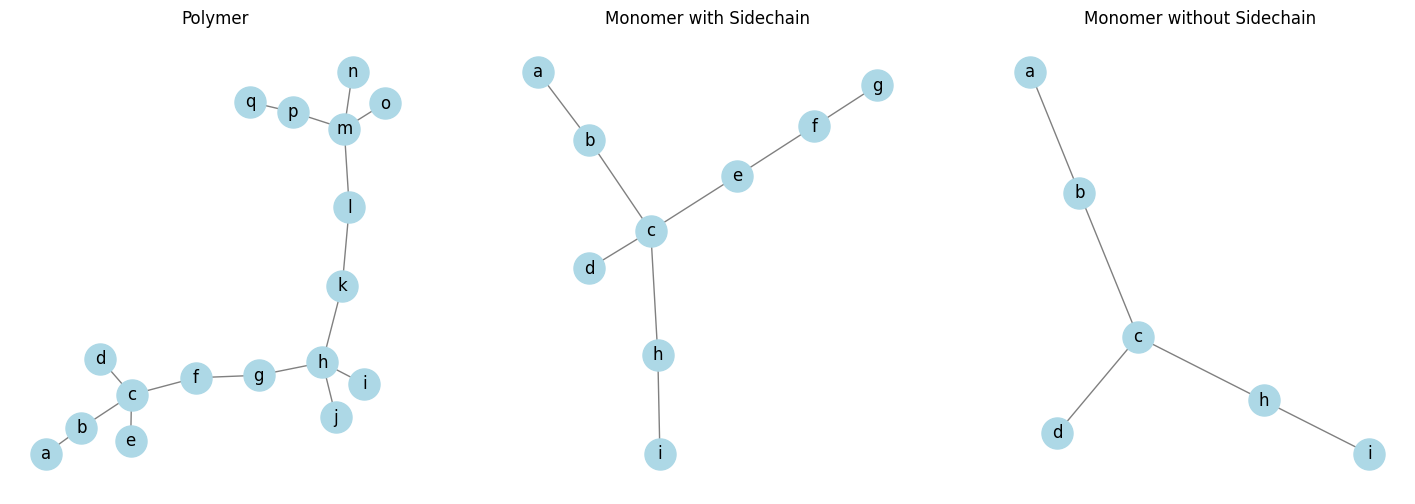

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.isomorphism import GraphMatcher

def remove_sidechain(G_monomer, sidechain_edge):
    G_monomer_no_sidechain = G_monomer.copy()
    G_monomer_no_sidechain.remove_edge(*sidechain_edge)

    # Extract the monomer and the sidechain subgraphs
    components = list(nx.connected_components(G_monomer_no_sidechain))
    if len(components) != 2:
        raise ValueError("Expected exactly two components after removing the sidechain edge.")

    # Identify which component is the monomer
    if sidechain_edge[0] in components[0]:
        monomer_nodes = components[0]
        sidechain_nodes = components[1]
    else:
        monomer_nodes = components[1]
        sidechain_nodes = components[0]

    G_monomer_no_sidechain = G_monomer.subgraph(monomer_nodes).copy()
    G_sidechain = G_monomer.subgraph(sidechain_nodes).copy()

    return G_monomer_no_sidechain, G_sidechain

def find_grafting_regions(G_polymer, G_monomer_no_sidechain):
    gm = GraphMatcher(G_polymer, G_monomer_no_sidechain)
    grafting_regions = set(G_polymer.nodes)

    for subgraph in gm.subgraph_isomorphisms_iter():
        monomer_nodes = set(subgraph.keys())
        grafting_regions -= monomer_nodes

    return grafting_regions

# Define the sidechain edge
sidechain_edge = ('c', 'e')  # Adjust this edge based on your specific graph

# Remove the sidechain to get the monomer without the sidechain
G_monomer_no_sidechain, G_sidechain = remove_sidechain(G_monomer, sidechain_edge)

# Find grafting regions in the polymer
grafting_regions = find_grafting_regions(G_polymer, G_monomer_no_sidechain)

# Print the results
print("Grafting regions:", grafting_regions)

# Draw the graphs
pos_polymer = nx.spring_layout(G_polymer)
pos_monomer = nx.spring_layout(G_monomer)
pos_monomer_no_sidechain = nx.spring_layout(G_monomer_no_sidechain)

plt.figure(figsize=(18, 6))

plt.subplot(131)
nx.draw(G_polymer, pos=pos_polymer, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('Polymer')

plt.subplot(132)
nx.draw(G_monomer, pos=pos_monomer, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('Monomer with Sidechain')

plt.subplot(133)
nx.draw(G_monomer_no_sidechain, pos=pos_monomer_no_sidechain, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('Monomer without Sidechain')

plt.show()

Units of the polymer: [{'a', 'd', 'c', 'b', 'f', 'g'}, {'a', 'e', 'c', 'b', 'f', 'g'}, {'l', 'k', 'f', 'h', 'g', 'j'}, {'l', 'k', 'f', 'h', 'g', 'i'}, {'a', 'd', 'c', 'b', 'f', 'g'}, {'a', 'e', 'c', 'b', 'f', 'g'}, {'l', 'q', 'k', 'p', 'o', 'm'}, {'l', 'q', 'k', 'p', 'n', 'm'}, {'l', 'k', 'f', 'h', 'g', 'j'}, {'l', 'k', 'f', 'h', 'g', 'i'}, {'l', 'q', 'k', 'p', 'o', 'm'}, {'l', 'q', 'k', 'p', 'n', 'm'}]
Grafting regions: set()


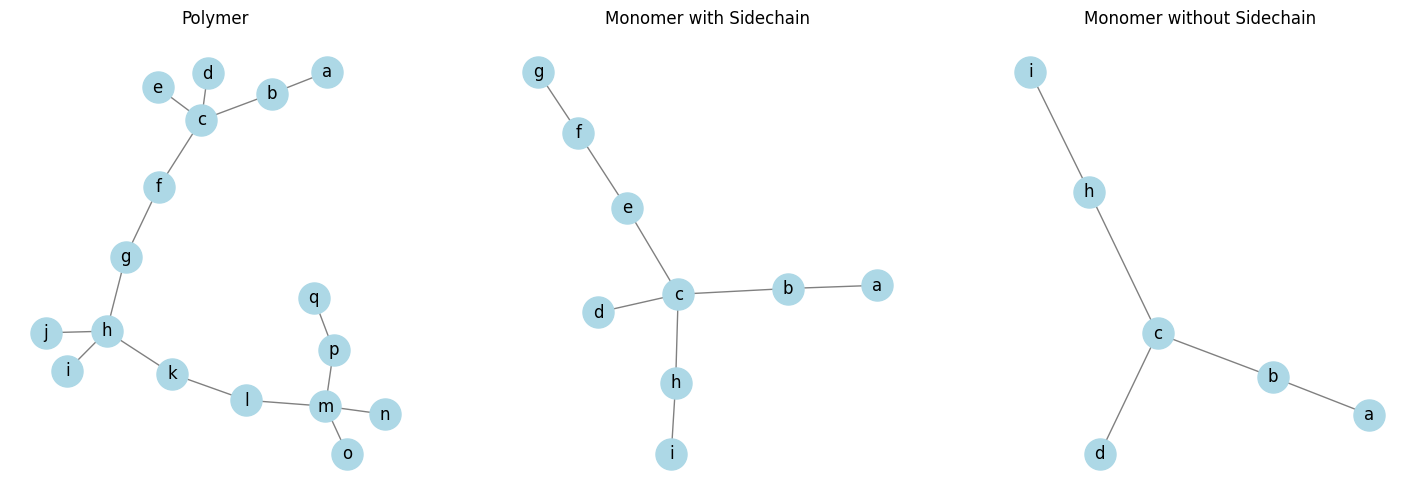

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.isomorphism import GraphMatcher

# Step 2: Identify the Sidechain on the Monomer
def remove_sidechain(G_monomer, sidechain_edge):
    G_monomer_no_sidechain = G_monomer.copy()
    G_monomer_no_sidechain.remove_edge(*sidechain_edge)

    # Extract the monomer and the sidechain subgraphs
    components = list(nx.connected_components(G_monomer_no_sidechain))
    if len(components) != 2:
        raise ValueError("Expected exactly two components after removing the sidechain edge.")

    # Identify which component is the monomer
    if sidechain_edge[0] in components[0]:
        monomer_nodes = components[0]
        sidechain_nodes = components[1]
    else:
        monomer_nodes = components[1]
        sidechain_nodes = components[0]

    G_monomer_no_sidechain = G_monomer.subgraph(monomer_nodes).copy()
    G_sidechain = G_monomer.subgraph(sidechain_nodes).copy()

    return G_monomer_no_sidechain, G_sidechain

# Step 3: Identify the Units of the Polymer
def find_units(G_polymer, G_monomer_no_sidechain):
    gm = GraphMatcher(G_polymer, G_monomer_no_sidechain)
    units = []
    for subgraph in gm.subgraph_isomorphisms_iter():
        units.append(set(subgraph.keys()))
    return units

# Step 4: Identify the Grafting Regions
def find_grafting_regions(G_polymer, G_monomer_no_sidechain, units):
    grafting_regions = set(G_polymer.nodes)
    for unit in units:
        grafting_regions -= unit
    return grafting_regions

# Example usage
sidechain_edge = ('c', 'e')  # Define the edge connecting the monomer and the sidechain

# Step 2: Remove the sidechain to get the monomer without the sidechain
G_monomer_no_sidechain, G_sidechain = remove_sidechain(G_monomer, sidechain_edge)

# Step 3: Find the units of the polymer
units = find_units(G_polymer, G_monomer_no_sidechain)

# Step 4: Find grafting regions in the polymer
grafting_regions = find_grafting_regions(G_polymer, G_monomer_no_sidechain, units)

# Print the results
print("Units of the polymer:", units)
print("Grafting regions:", grafting_regions)

# Draw the graphs
pos_polymer = nx.spring_layout(G_polymer)
pos_monomer = nx.spring_layout(G_monomer)
pos_monomer_no_sidechain = nx.spring_layout(G_monomer_no_sidechain)

plt.figure(figsize=(18, 6))

plt.subplot(131)
nx.draw(G_polymer, pos=pos_polymer, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('Polymer')

plt.subplot(132)
nx.draw(G_monomer, pos=pos_monomer, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('Monomer with Sidechain')

plt.subplot(133)
nx.draw(G_monomer_no_sidechain, pos=pos_monomer_no_sidechain, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('Monomer without Sidechain')

plt.show()


Units of the polymer: [{'a', 'd', 'e', 'c', 'b', 'f', 'g', 'h'}, {'a', 'd', 'e', 'c', 'b', 'f', 'g', 'h'}, {'l', 'k', 'f', 'h', 'g', 'j', 'i', 'm'}, {'l', 'k', 'f', 'h', 'g', 'j', 'i', 'm'}, {'l', 'c', 'k', 'f', 'h', 'g', 'j', 'i'}, {'l', 'c', 'k', 'f', 'h', 'g', 'j', 'i'}, {'l', 'q', 'k', 'p', 'h', 'o', 'n', 'm'}, {'l', 'q', 'k', 'p', 'h', 'o', 'n', 'm'}, {'d', 'e', 'c', 'b', 'f', 'g', 'h'}, {'d', 'e', 'c', 'b', 'f', 'g', 'h'}, {'d', 'e', 'c', 'b', 'f', 'g', 'h'}, {'d', 'e', 'c', 'b', 'f', 'g', 'h'}, {'d', 'e', 'c', 'b', 'f', 'g', 'h'}, {'d', 'e', 'c', 'b', 'f', 'g', 'h'}, {'l', 'k', 'h', 'g', 'j', 'i', 'm'}, {'l', 'k', 'h', 'g', 'j', 'i', 'm'}, {'l', 'k', 'h', 'g', 'j', 'i', 'm'}, {'c', 'k', 'f', 'h', 'g', 'j', 'i'}, {'c', 'k', 'f', 'h', 'g', 'j', 'i'}, {'l', 'k', 'h', 'g', 'j', 'i', 'm'}, {'l', 'k', 'h', 'g', 'j', 'i', 'm'}, {'c', 'k', 'f', 'h', 'g', 'j', 'i'}, {'c', 'k', 'f', 'h', 'g', 'j', 'i'}, {'l', 'k', 'h', 'g', 'j', 'i', 'm'}, {'c', 'k', 'f', 'h', 'g', 'j', 'i'}, {'c', 'k', '

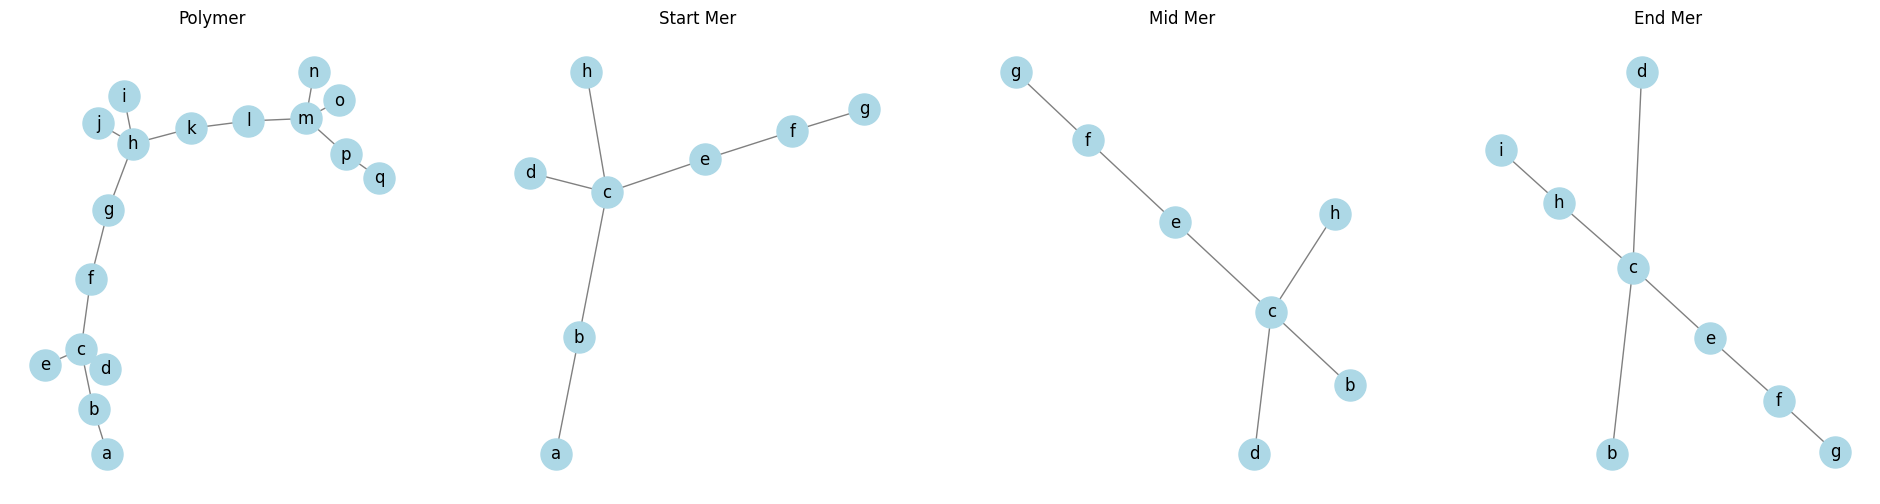

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.isomorphism import GraphMatcher

# Step 1: Define Functions to Remove Start and End Hydrogens from the Monomer
def remove_hydrogens(G_monomer, start_hydrogen, end_hydrogen):
    G_start_mer = G_monomer.copy()
    G_mid_mer = G_monomer.copy()
    G_end_mer = G_monomer.copy()

    # Remove start hydrogen for mid_mer and end_mer
    G_mid_mer.remove_node(start_hydrogen)
    G_end_mer.remove_node(start_hydrogen)

    # Remove end hydrogen for start_mer and mid_mer
    G_start_mer.remove_node(end_hydrogen)
    G_mid_mer.remove_node(end_hydrogen)

    return G_start_mer, G_mid_mer, G_end_mer

# Step 2: Identify the Units of the Polymer
def find_units(G_polymer, G_start_mer, G_mid_mer, G_end_mer):
    gm_start = GraphMatcher(G_polymer, G_start_mer)
    gm_mid = GraphMatcher(G_polymer, G_mid_mer)
    gm_end = GraphMatcher(G_polymer, G_end_mer)

    units = []
    for gm in [gm_start, gm_mid, gm_end]:
        for subgraph in gm.subgraph_isomorphisms_iter():
            units.append(set(subgraph.keys()))

    return units

# Step 3: Map the Polymer Accordingly
def find_grafting_regions(G_polymer, units):
    grafting_regions = set(G_polymer.nodes)
    for unit in units:
        grafting_regions -= unit
    return grafting_regions

# Example usage
start_hydrogen = 'a'  # Define the start hydrogen atom
end_hydrogen = 'i'    # Define the end hydrogen atom

# Step 1: Remove start and end hydrogens to get start_mer, mid_mer, and end_mer
G_start_mer, G_mid_mer, G_end_mer = remove_hydrogens(G_monomer, start_hydrogen, end_hydrogen)

# Step 2: Find the units of the polymer
units = find_units(G_polymer, G_start_mer, G_mid_mer, G_end_mer)

# Step 3: Find grafting regions in the polymer
grafting_regions = find_grafting_regions(G_polymer, units)

# Print the results
print("Units of the polymer:", units)
print("Grafting regions:", grafting_regions)

# Draw the graphs
pos_polymer = nx.spring_layout(G_polymer)
pos_start_mer = nx.spring_layout(G_start_mer)
pos_mid_mer = nx.spring_layout(G_mid_mer)
pos_end_mer = nx.spring_layout(G_end_mer)

plt.figure(figsize=(24, 6))

plt.subplot(141)
nx.draw(G_polymer, pos=pos_polymer, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('Polymer')

plt.subplot(142)
nx.draw(G_start_mer, pos=pos_start_mer, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('Start Mer')

plt.subplot(143)
nx.draw(G_mid_mer, pos=pos_mid_mer, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('Mid Mer')

plt.subplot(144)
nx.draw(G_end_mer, pos=pos_end_mer, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title('End Mer')

plt.show()

# Junk

#519c9a
#558988
#5a7776
#5e6564
#635352
#674140
#6c2f2e
#701d1c
#750b0b


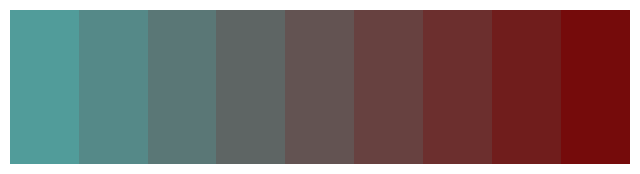

In [ ]:
import matplotlib.pyplot as plt

def generate_gradient(start_rgb, end_rgb, n):
    """
    Generate a list of n colors forming a gradient between start_rgb and end_rgb.

    :param start_rgb: Tuple of the starting RGB color (r, g, b)
    :param end_rgb: Tuple of the ending RGB color (r, g, b)
    :param n: Number of colors to generate
    :return: List of HEX color values
    """
    gradient = []
    for i in range(n):
        intermediate_rgb = (
            int(start_rgb[0] + (end_rgb[0] - start_rgb[0]) * i / (n - 1)),
            int(start_rgb[1] + (end_rgb[1] - start_rgb[1]) * i / (n - 1)),
            int(start_rgb[2] + (end_rgb[2] - start_rgb[2]) * i / (n - 1))
        )
        # Convert RGB to HEX
        gradient.append('#{:02x}{:02x}{:02x}'.format(*intermediate_rgb))

    return gradient

# Define the starting and ending RGB values
start_rgb = (81, 156, 154)
end_rgb = (117, 11, 11)

# Number of colors to generate
n_colors = 9

# Generate the gradient
colors = generate_gradient(start_rgb, end_rgb, n_colors)

# Display the HEX values
for i, color in enumerate(colors):
    print(f"{color}")

# Optional: Visualize the gradient
plt.figure(figsize=(8, 2))
plt.imshow([list(map(lambda x: tuple(int(x[i:i+2], 16) for i in (1, 3, 5)), colors))], aspect='auto')
plt.axis('off')
plt.show()

In [ ]:
import colorsys

def rgb_to_hex(rgb):
    """
    Convert an RGB tuple to a HEX string.
    """
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

def hex_to_rgb(hex):
    """
    Convert a HEX string to an RGB tuple.
    """
    hex = hex.lstrip('#')
    return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

def complementary_color(rgb):
    """
    Generate the complementary color for a given RGB value.
    """
    # Complementary color in RGB is simply (255-R, 255-G, 255-B)
    return (255 - rgb[0], 255 - rgb[1], 255 - rgb[2])

def generate_complementary_scheme(color1, color2):
    """
    Generate complementary color schemes for two provided colors.

    :param color1: HEX string or RGB tuple of the first color
    :param color2: HEX string or RGB tuple of the second color
    :return: A dictionary with the complementary schemes
    """
    # Convert HEX to RGB if necessary
    if isinstance(color1, str):
        color1 = hex_to_rgb(color1)
    if isinstance(color2, str):
        color2 = hex_to_rgb(color2)

    # Generate complementary colors
    comp_color1 = complementary_color(color1)
    comp_color2 = complementary_color(color2)

    # Return the original and complementary colors in HEX
    return {
        "Color 1": rgb_to_hex(color1),
        "Complementary of Color 1": rgb_to_hex(comp_color1),
        "Color 2": rgb_to_hex(color2),
        "Complementary of Color 2": rgb_to_hex(comp_color2)
    }

# Example colors (You can replace these with your own)
color1 = "#1e90ff"  # DodgerBlue
color2 = "#ff4500"  # OrangeRed

# Generate complementary color schemes
scheme = generate_complementary_scheme(color1, color2)

# Display the results
for key, value in scheme.items():
    print(f"{key}: {value}")

Color 1: #1e90ff
Complementary of Color 1: #e16f00
Color 2: #ff4500
Complementary of Color 2: #00baff


Color 1: #519c9a
Color 2: #587f7d
Color 3: #5f6260
Color 4: #664544
Color 5: #6d2827
Color 6: #750b0b


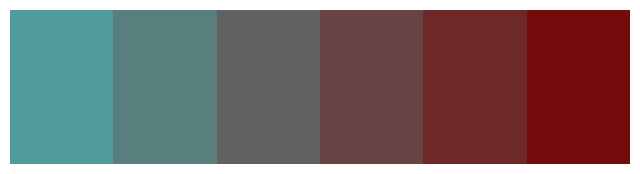

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def blend_colors(color1, color2, n):
    """
    Blend two colors to create a smooth transition between them.

    :param color1: HEX string or RGB tuple of the first color
    :param color2: HEX string or RGB tuple of the second color
    :param n: Number of colors to generate in the scheme
    :return: List of HEX color values forming a transition from color1 to color2
    """
    # Convert HEX to RGB if necessary
    if isinstance(color1, str):
        color1 = hex_to_rgb(color1)
    if isinstance(color2, str):
        color2 = hex_to_rgb(color2)

    # Generate the gradient
    gradient = []
    for i in range(n):
        intermediate_rgb = (
            int(color1[0] + (color2[0] - color1[0]) * i / (n - 1)),
            int(color1[1] + (color2[1] - color1[1]) * i / (n - 1)),
            int(color1[2] + (color2[2] - color1[2]) * i / (n - 1))
        )
        gradient.append(rgb_to_hex(intermediate_rgb))

    return gradient

def rgb_to_hex(rgb):
    """
    Convert an RGB tuple to a HEX string.
    """
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

def hex_to_rgb(hex):
    """
    Convert a HEX string to an RGB tuple.
    """
    hex = hex.lstrip('#')
    return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

# Example colors (You can replace these with your own)
color1 = "#519c9a"
color2 = "#750b0b"

# Number of colors in the scheme
n_colors = 6

# Generate the color scheme bridging the gap between the two colors
color_scheme = blend_colors(color1, color2, n_colors)

# Display the HEX values
for i, color in enumerate(color_scheme):
    print(f"Color {i + 1}: {color}")

# Visualize the color scheme
plt.figure(figsize=(8, 2))
plt.imshow([list(map(lambda x: tuple(int(x[i:i+2], 16) for i in (1, 3, 5)), color_scheme))], aspect='auto')
plt.axis('off')
plt.show()
